In [2]:
import numpy as np
import pandas as pd
import re
import datetime
import IPython
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from matplotlib.lines import Line2D
import dexplot as dxp
from scipy.stats import fisher_exact, ranksums, chi2, norm
from sklearn.preprocessing import LabelEncoder
from statsmodels.sandbox.stats.multicomp import multipletests
from sksurv.nonparametric import kaplan_meier_estimator

from scipy.stats import fisher_exact, spearmanr
from sklearn.preprocessing import LabelEncoder

now = datetime.datetime.now()
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
###############
# Logrank tests
###############
  
def custom_logrank_test(dataframes, type='CMH_logrank'):
    list_data_y = []

    for df in dataframes:
        df_slct = df[['os_status', 'os']].dropna()

        data_y = np.array([(status, time) for status, time in zip(df_slct.os_status, df_slct.os)],
                          dtype=[('os_status', '?'), ('os', np.float)])
        list_data_y.append(data_y)

    n_groups = len(list_data_y)
    n = sum([l.shape[0] for l in list_data_y])
    df = n_groups - 1

    d = np.zeros((1, n_groups - 1))  # Row vector d sums number of events (deaths) for first n_groups-1 groups pver each distinct time
    E = np.zeros((1, n_groups - 1))  # Row vector d sums expected number of events (deaths) for first n_groups-1 groups over each distinct time
    V = np.zeros((n_groups - 1, n_groups - 1))  # Matrix V will sums variances of number of events (deaths) for first n_groups-1 groups over distinct times
    W = []  # List of list W will record scores for each group at each distinct time
    r_t = [l.shape[0] for l in list_data_y]  # r_t stores at each time t the number at risk in each group

    lbda = 0  # Lbda is the Nelson-Aalen estimate of the cumulative hazard for all groups combined
    # It is used as a score for the linear rank test statistic

    for t in sorted(np.unique(np.concatenate([l['os'] for l in list_data_y]).flatten())):
        d_t = []
        E_t = []
        W_t = []

        for k in range(n_groups):
            d_t.append(list_data_y[k][(list_data_y[k]['os'] == t) & (list_data_y[k]['os_status'] == True)].shape[0])
        for k in range(n_groups):
            E_t.append(sum(d_t) * r_t[k] / sum(r_t))

        d += np.array([d_t[:-1]])
        E += np.array([E_t[:-1]])
        lbda += sum(d_t) / sum(r_t)

        for k in range(n_groups):
            w_k = []
            for s in list_data_y[k][list_data_y[k]['os'] == t]:
                if s['os_status'] == True:
                    w_k.append(1 - lbda)
                else:
                    w_k.append(-lbda)
            W_t.append(w_k)
        W.append(W_t)

        if sum(r_t) > 1:
            V_t = []
            for i in range(n_groups):
                r_i = []
                for j in range(n_groups):
                    if i != j:
                        r_i.append(-(sum(r_t) - sum(d_t)) * sum(d_t) * r_t[i] * r_t[j] / ((sum(r_t) - 1) * sum(r_t) ** 2))  # Pay attention to the - sign for covariance term
                    else:
                        r_i.append((sum(r_t) - sum(d_t)) * sum(d_t) * r_t[i] * (sum(r_t) - r_t[i]) / ((sum(r_t) - 1) * sum(r_t) ** 2))
                V_t.append(r_i)
            V_t = np.array(V_t)
            V += (V_t[:-1, :-1])

        r_t = [r - e[e['os'] == t].shape[0] for r, e in zip(r_t, list_data_y)]  # Update number of patients at risk in each group

    if type == 'CMH_logrank':  # Cochran-Mantel-Haenszel

        # Suppose we have k (2x2) tables, all independent and we want to test for
        # a common group effect. This is the Cochran-Mantel-Haenszel that, in case
        # of survival analysis, tests for odds ratio being 1 at all times

        # Null hypothesis H0: odds ratio is 1 for all tables

        statistic = (d - E).dot(np.linalg.inv(V).dot(d - E))
        p_value = 1 - chi2.cdf(statistic, df)

    elif type == 'Linear_rank_logrank':
        if n_groups > 2:
            raise ValueError("Linear_rank_logrank statistic is not yet implemented for comparison between more than 2 groups.")

        else:
            # The linear rank version of the logrank test is based on adding up "scores" for one of the 2 groups
            # The "score" is based on the Nelson-Aalen estimator
            # Null hypothesis H0: odds ratio is 1 for all tables

            S = np.concatenate(pd.DataFrame(W).iloc[:, 0]).sum()
            V = list_data_y[0].shape[0] * list_data_y[1].shape[0] * sum([sum(np.concatenate(pd.DataFrame(W).iloc[:, i]) ** 2) for i in range(n_groups)]) / (n * (n - 1))
            statistic = S ** 2 / V
            p_value = 1 - chi2.cdf(statistic, df)

    else:
        raise ValueError("Unsupported type %s. Choose one of: 'CHM_logrank', 'linear_rank_logrank'." % type)

    return statistic, df, p_value

  
#######################################
# Functions to plot Kaplan-Meier curves
#######################################

def plot_km(dataframe, label, mask_label, ax, color=None, label_legend=False, lw=None, scatter_s=None):

    """
    This function creates a plot with a Kaplan-Meier curve of overall survival
    for the input dataframe. The latter must have columns "os" and "os_status".

    :param dataframe: pandas.DataFrame
        Input, typically output of selection of a particular population
    :param label: string
        Name to give to the population of dataframe
    :param mask_label: string
        Mask used for creating the input dataframe
    :param ax: Axes object
        Axes in which to plot
    :param color: string
        Default:None
    :param label_legend: boolean
        If True, uses mask_label to label the curve. Default:False
    :param lw: integer
        Linewidth of the curves. Default:None
    :param scatter_s: integer
        Size of the scatter points for censored patients. Default: None
    :return:
    """

    df_nmos = dataframe[['os_status', 'os']].dropna()

    if df_nmos.shape[0] == 0:
        print('Patients for dataset %s and mask %s all N.A for os or os_status' % (label,mask_label))
    elif (df_nmos.os_status.nunique() == 1 and df_nmos.os_status.unique()[0] == False):
        print('Patients for dataset %s and mask %s are all censored' % (label,mask_label))
    else:
        data_y = np.array([(status, time) for status, time in zip(df_nmos.os_status, df_nmos.os)],
                          dtype=[('os_status', '?'), ('os', np.float)])

        time, survival_prob = kaplan_meier_estimator(data_y['os_status'], data_y['os'])
        time = np.insert(time, 0, 0)
        survival_prob = np.insert(survival_prob, 0, 1.0)

        time_censored, prob_censored = [], []
        for t, p in zip(time, survival_prob):
            if False in data_y[data_y['os'] == t]['os_status']:
                time_censored.append(t), prob_censored.append(p)

        ax.scatter(time_censored, prob_censored, color=color, marker='+', s=scatter_s)
        if label_legend:
            ax.step(time, survival_prob, color=color, label='%s n=%d'%(mask_label,data_y.shape[0]), linewidth=lw)
        else:
            ax.step(time, survival_prob, color=color, label='n=%d'%data_y.shape[0], linewidth=lw)

def plot_compare_km(dataframes, labels, mask_labels, ax, colors, linestyles=['-','-'], label_legend=None, test_statistic='default', xy_statistic=(0.6,0.8), font_size_statistic='small', lw=None,
                    scatter_s=None):
    """
    This function creates a plot with Kaplan-Meier curves of overall survival
    for the list of dataframes. The latter must have columns "os" and "os_status".

    :param dataframes: list
        Groups for the KM curves, list of dataframes.
    :param labels: list
        List of strings used to label the curves if label_legend is 'dataset'
    :param mask_labels: list
        List of strings used to label the curves if label_legend is 'mask' and to print warning messages
    :param ax: Axes object
        Axes in which to plot
    :param colors: list
        List of colors names
    :param linestyles: list
        List of linestyles to be used for curves. Must be same size as dataframes. Default: ['-','-']
    :param label_legend: string
        Must be one of 'dataset', 'label' or None. This tells which labels to put in the legend. Default: None
    :param test_statistic: string
        Which test_statistic to use for comparing curves. For the moment only 'CMH_logrank' is available for more than 2 curves and 'linear_rank_logrank' for 2 curves.
        Default:'CMH_logrank'
    :param xy_statistic: tuple
        Coordinates in the axes fraction units to print the p-value of the test. Default: (0.6, 0.8)
    :param font_size_statistic: string
        Fontsize to print the p-value of the test. Default: 'small'
    :param lw: integer
        Linewidth of the curves. Default:None
    :param scatter_s: integer
        Size of the scatter points for censored patients. Default: None
    :return:
    """
    list_data_y = []

    for df, label, mask_label, c, ls in zip(dataframes, labels, mask_labels, colors, linestyles):
        if df.shape[0] == 0:
            print('0 patient for dataset %s and mask %s' % (label, mask_label))

        else:
            df_slct = df[['os_status', 'os']].dropna()

            if df_slct.shape[0] == 0:
                print('Patients for dataset %s and mask %s all N.A for os or os_status' % (label, mask_label))
            elif (df_slct.os_status.nunique() == 1 and df_slct.os_status.unique()[0] == False):
                print('Patients for dataset %s and mask %s are all censored' % (label, mask_label))
            else:
                data_y = np.array([(status, time) for status, time in zip(df_slct.os_status, df_slct.os)],
                                  dtype=[('os_status', '?'), ('os', np.float)])
                list_data_y.append(data_y)
                time, survival_prob = kaplan_meier_estimator(data_y['os_status'], data_y['os'])
                time = np.insert(time, 0, 0)
                survival_prob = np.insert(survival_prob, 0, 1.0)

                time_censored, prob_censored = [], []
                for t,p in zip(time,survival_prob):
                    if False in data_y[data_y['os']==t]['os_status']:
                        time_censored.append(t), prob_censored.append(p)

                ax.scatter(time_censored, prob_censored, color=c, marker='+', s=scatter_s)
                if label_legend==None:
                    ax.step(time, survival_prob, color=c, label='n=%d' % data_y.shape[0], linestyle=ls, linewidth=lw)
                elif label_legend=='dataset':
                    ax.step(time, survival_prob, color=c, label='%s n=%d' % (label, data_y.shape[0]), linestyle=ls, linewidth=lw)
                elif label_legend=='mask':
                    ax.step(time, survival_prob, color=c, label='%s n=%d' % (mask_label, data_y.shape[0]), linestyle=ls, linewidth=lw)
                else:
                    raise ValueError('Unsupported value of label_legend \n Must be one of [None,"dataset","mask"]')

    dataframes_statistic = []
    for df in dataframes:
        if df.shape[0] > 5:
            dataframes_statistic.append(df)

    if len(dataframes_statistic) >= 2:
        if test_statistic == 'CMH_logrank':
            statistic, df, p_value = custom_logrank_test(dataframes_statistic, type='CMH_logrank')

            if p_value < 0.001:
                s = '$\chi^2$ P<0.001'
            else:
                s = '$\chi^2$ P=%.3f' % p_value
            ax.annotate(s=s, xy=xy_statistic, xycoords='axes fraction', fontsize=font_size_statistic)

        elif test_statistic == 'Linear_rank_logrank':
            if len(list_data_y) > 2:
                raise ValueError('For test_statistic equal to Linear_rank_logrank only 2 groups are permitted')
            else:
                statistic, df, p_value = custom_logrank_test(dataframes_statistic, type='Linear_rank_logrank')

                if p_value < 0.001:
                    s = '$\chi^2$ P<0.001'
                else:
                    s = '$\chi^2$ P=%.3f' % p_value
                ax.annotate(s=s, xy=xy_statistic, xycoords='axes fraction', fontsize=font_size_statistic)

        elif test_statistic != None:
            raise ValueError("Unsupported value of test_statistic \n Must be one of: None, CMH_logrank, Linear_rank_logrank.")

In [4]:
continuous_correlates = ["age","wbc","hb","plt","bm_blasts","os",]
#categorical_correlates = ["gender","ahd","perf_status","secondary","os_status","eln_2017_ratio"]
categorical_correlates = ["gender","ahd","perf_status","secondary","os_status","eln_2017"]
df= pd.read_csv("../../clustering/clustering_Final_1/df_final_full_component.tsv",sep=' ')
df.loc[df['eln_2017'] == 1, 'eln'] = "adverse"
df.loc[df['eln_2017'] == 2, 'eln'] = "intermediate"
df.loc[df['eln_2017'] == 3, 'eln'] = "favorable"
df.loc[df.age<60,"age_median"]=0
df.loc[df.age>=60,"age_median"]=1
#df_initial = pd.read_csv("../../../data/initial_dataset/Master_04_10_2019.csv",low_memory=False)
#df_initial.index = df_initial.data_pd
#del df_initial.index.name
#df = df.merge(df_initial[continuous_correlates+categorical_correlates],left_index=True,right_index=True)

In [7]:
# Keep columns with frequency equal or higher than 2%

mut_dict = {'wt': 0, 'mut': 1}

gene_cols = sorted([c for c in df.columns if any((x.isupper()) & ~( c.startswith( 'final' )) & ~( c.startswith( 'full' )) & ~( c.startswith( 'overlap' )) for x in c)])
gene_freq_cols = df.loc[:, gene_cols].sum(axis=0).sort_values(ascending=False)
gene_freq_cols = list(gene_freq_cols[gene_freq_cols >= 0.02*df.shape[0]].index)


cyto_cols = [x for x in df.columns if any(x.startswith(s) for s in
              ['t_', 'der', 'add', 'i_', 'dup', 'del', 'add', 'dic', 'inv', 'abn', 'plus', 'minus', 'mono', 'complex','others_'])
              or x in (['ring', 'mar', 'dmin', 'hsr', 'ins'])]


cyto_freq_cols = df.loc[:, cyto_cols].sum(axis=0).sort_values(ascending=False)
cyto_freq_cols = list(cyto_freq_cols.loc[cyto_freq_cols >=  0.02*df.shape[0]].index)

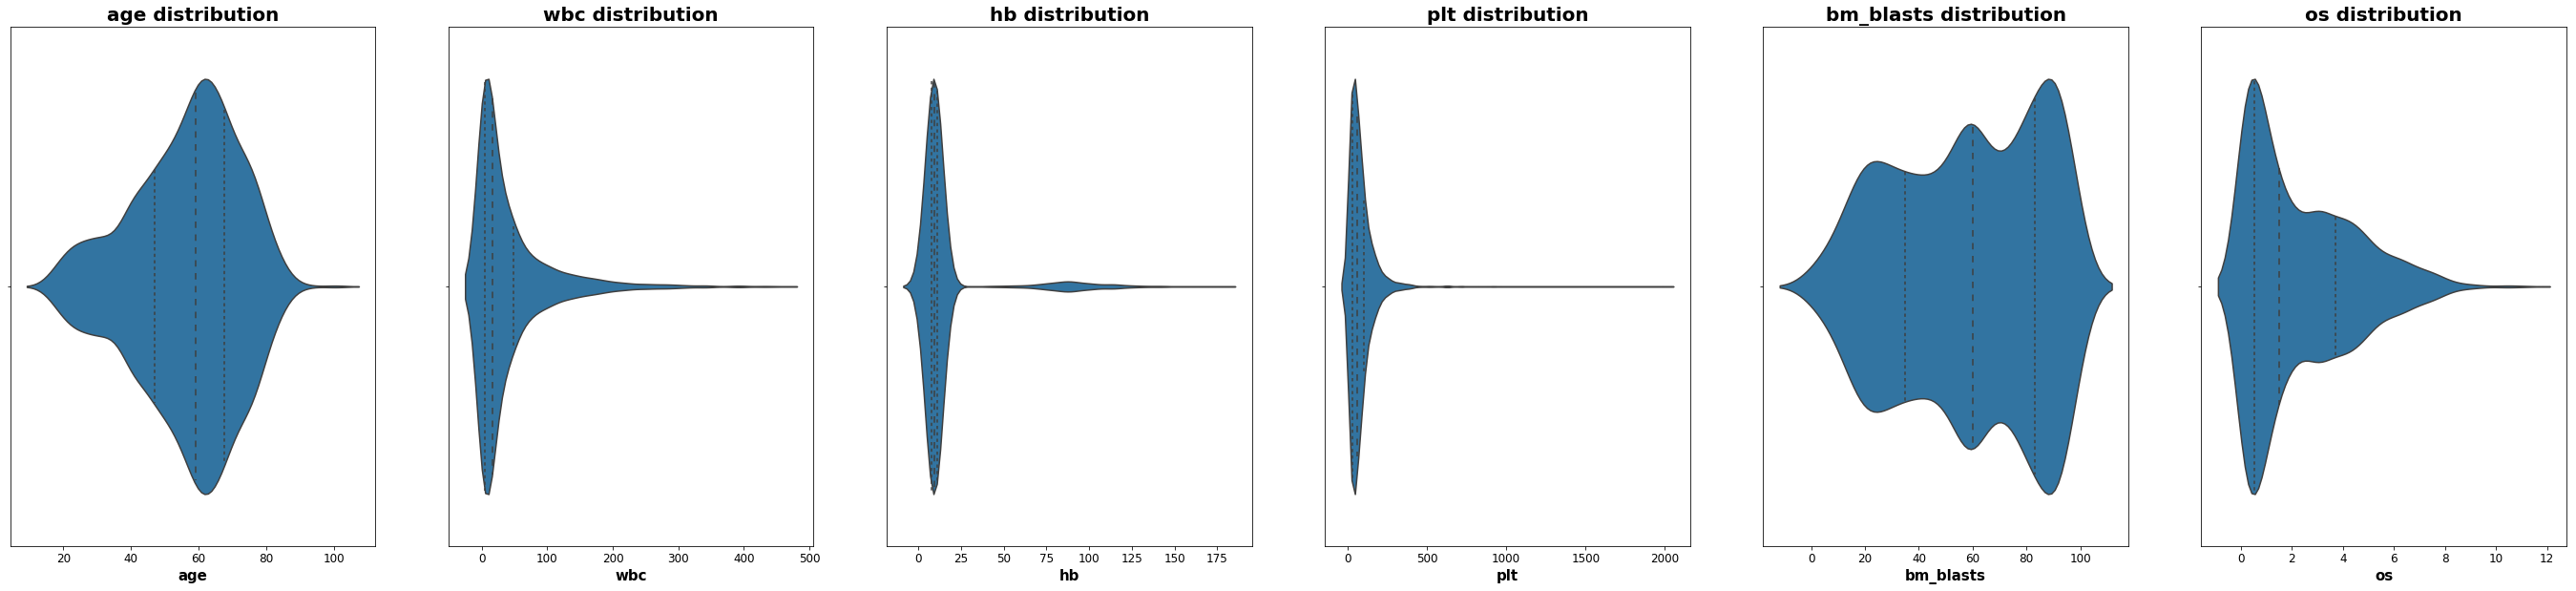

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(48,10))
for i,cont in enumerate(continuous_correlates):
    sns.violinplot(x=cont,inner='quartile',data=df,ax=ax[i])
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_xlabel(cont, fontsize=15, fontweight='bold')
    ax[i].set_ylabel('')
    ax[i].set_title(cont + ' distribution', fontsize=20, fontweight='bold')
#plt.show()
fig.savefig('graphs/continuous_variables_distribution.pdf', format='pdf')

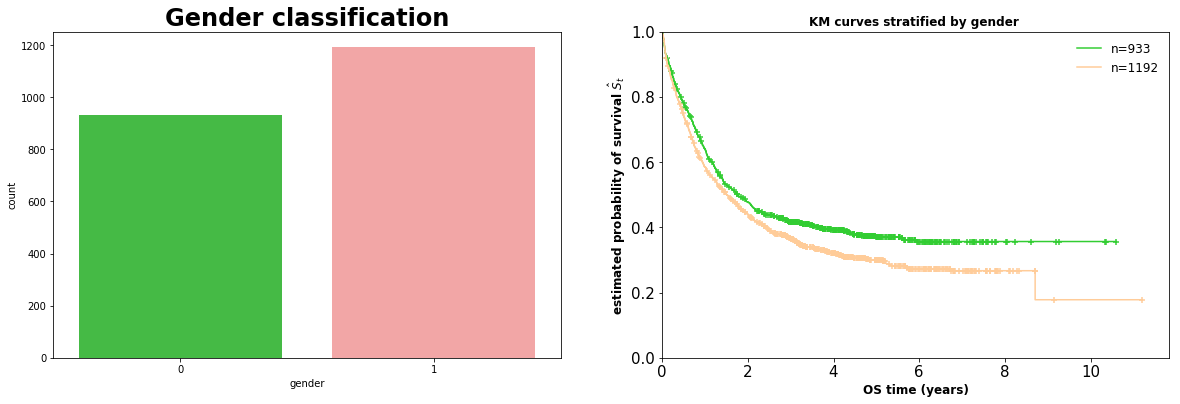

In [9]:
# =============================================================================
# KM curves comparison eln_2017 classification
# =============================================================================

# Simple pies of classes frequency


cmap = cm.get_cmap('tab10')
colors = [cmap(i) for i in range(10)]
colors_dict = {k: v for k, v in zip(df.gender.value_counts().index, colors)}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

colors_ordered = [colors_dict[x] for x in df.gender.value_counts().index]
colors_ordered = ['limegreen', '#ff9999', '#ffcc99']
sns.countplot(x="gender", data=df,ax=ax[0],palette=colors_ordered)
ax[0].set_title("Gender classification", fontweight='bold', fontsize=24)



for cl, c in zip([0,1], ['limegreen', '#ffcc99']):
    mask = (df.gender==cl)
    plot_km(dataframe=df.loc[mask],
            mask_label=cl,
            ax=ax[1],
            color=c,
           label='df')


ax[1].set_ylabel('estimated probability of survival $\hat{S}_t$', fontsize='large', fontweight='bold')
ax[1].set_xlabel('OS time (years)', fontsize='large', fontweight='bold')
ax[1].set_xlim(left=0.)
ax[1].set_ylim([0,1])
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].legend(loc='upper right', fontsize='large', frameon=False)
ax[1].set_title('KM curves stratified by gender ', size='large', fontweight='bold')
fig.savefig('graphs/eln_survival_plots.pdf', format='pdf')
plt.show()

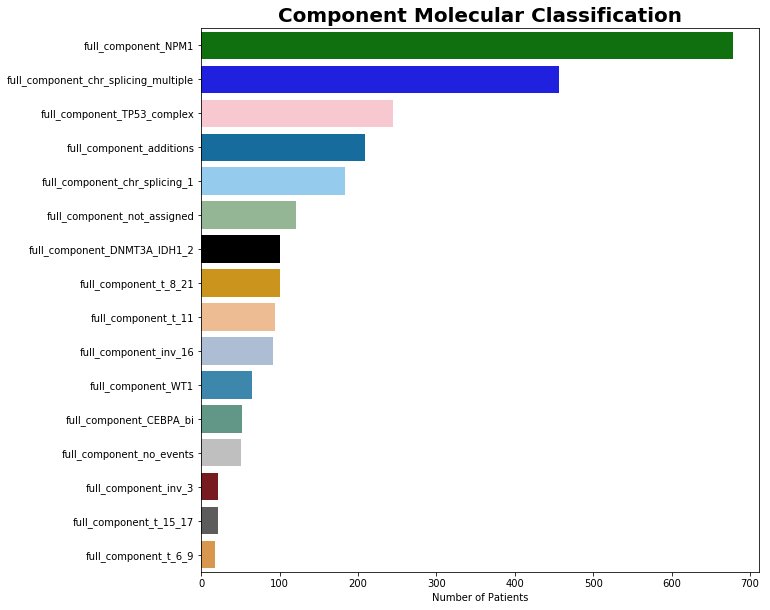

In [10]:
eln_classes = ['favorable', 'intermediate', 'adverse']
    
cmap = cm.get_cmap('tab20')
colors = [cmap(i) for i in range(20)]
colors_dict = {k:v for k,v in zip(df.final_component.value_counts().index, colors)}   

colors_ordered = [colors_dict[x] for x in df.final_component.value_counts().index]
fig,ax =  plt.subplots(nrows=1,ncols=1,figsize=(10,10))
ax = sns.barplot(x=df[[c for c in df.columns if ( c.startswith( 'full' ))]].sum().sort_values(ascending=True).values,y=df[[c for c in df.columns if ( c.startswith( 'full' ))]].sum().sort_values(ascending=True).keys(),
                palette=["#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green"])
ax.set_title("Component Molecular Classification", fontweight='bold', fontsize=20)
ax.set_xlabel("Number of Patients")
ax.invert_yaxis()
#lightgoldenrod","darkseagreen","lightskyblue","mistyrose4","#0072B2","pink"

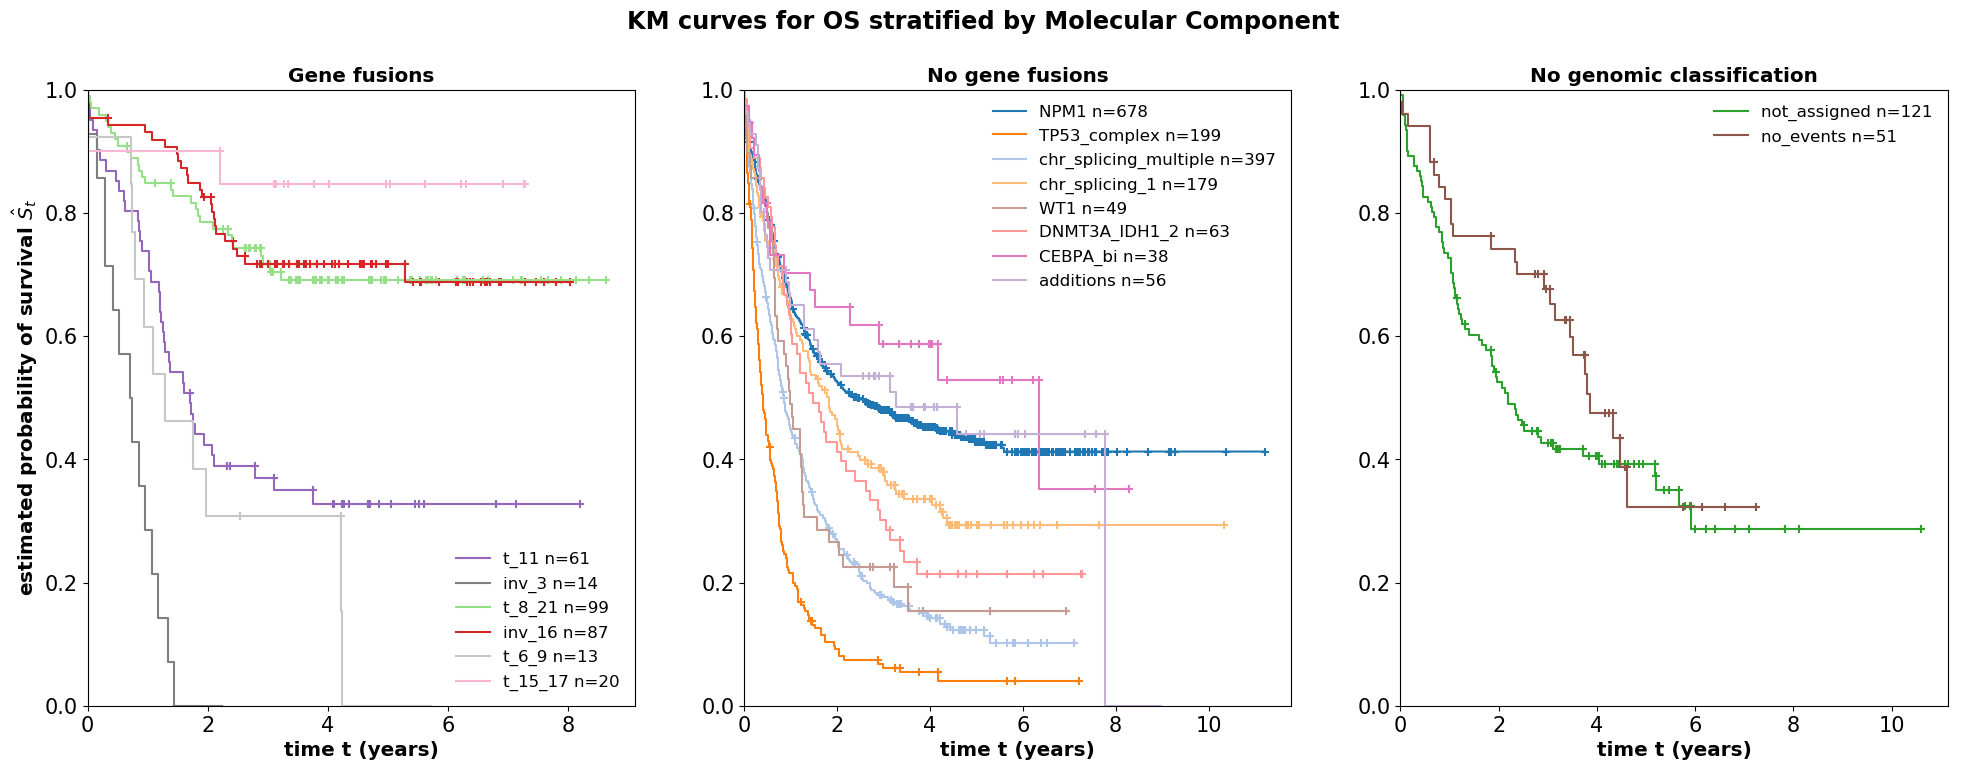

In [11]:
# OS KM curves Ulm and Cardiff for NEJM classification

plt.style.use('default')
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(24,8))
groups = {'Gene fusions':['t_8_21','t_11','t_15_17','t_6_9','inv_3','inv_16'],
          'No gene fusions':['CEBPA_bi','NPM1','TP53_complex','DNMT3A_IDH1_2','WT1','additions','chr_splicing_1','chr_splicing_multiple'],
          'No genomic classification':['not_assigned','no_events']}
cmap = cm.get_cmap('tab20')
colors = [cmap(i) for i in range(17)]
colors_dict = {k:v for k,v in zip(df.final_component.value_counts().index, colors)}   

for cl in df.final_component.unique():
    mask = df.final_component==cl

    for (k, v), i in zip(groups.items(),range(3)):
        if cl in v:
            plot_km(dataframe=df.loc[mask],
                    label='Component',
                    mask_label=cl,
                    ax=ax[i],
                    color=colors_dict[cl],
                    label_legend=True)

for k,i in zip(groups.keys(), range(3)):
    if i==0:
        #ax[i].annotate('t_15_17', xy=(8, 0.69), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('t_8_21', xy=(8.2, 0.6), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('inv(16)', xy=(10, 0.775), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('MLL_fusions', xy=(8, 0.18), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('t_6_9', xy=(5, 0.235), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('inv(3)', xy=(2.5, 0.08), fontweight='bold', fontsize='x-large')
        ax[i].set_ylabel('estimated probability of survival $\hat{S}_t$', fontsize='x-large', fontweight='bold')

    #if i==1:
        #ax[i].annotate('CEBPA_bi',xy=(8,0.70), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('NPM1', xy=(11 , 0.42), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('IDH2_R172', xy=(6, 0.57), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('TP53_aneuploidy', xy=(4, 0.12), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('Chromatin-spliceosome', xy=(6.0, 0.28), fontweight='bold', fontsize='x-large')

    #if i==2:
        #ax[i].annotate('No detected driver',xy=(8.5, 0.46), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('No class', xy=(4.5 , 0.32), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('Ambiguous adv', xy=(10, 0.27), fontweight='bold', fontsize='x-large')
        #ax[i].annotate('Ambiguous fav', xy=(10, 0.39), fontweight='bold', fontsize='x-large')

    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='large', frameon=False)
    ax[i].set_xlim(left=0)
    ax[i].set_ylim([0,1])
    ax[i].set_xlabel('time t (years)', fontsize='x-large', fontweight='bold')
    ax[i].set_title('%s' % k, fontsize='x-large', fontweight='bold')

fig.suptitle('KM curves for OS stratified by Molecular Component ', fontweight='bold', fontsize='xx-large')
fig.savefig('graphs/km_curves_molecular_component.pdf', format='pdf')
plt.show()


In [32]:
comp_cols=[col for col in df if (col.startswith('final_component_') & ~col.endswith('molecular') & ~col.endswith('numeric')) ]
comp='full_component_chr_splicing_1'
eln_classes = ['favorable', 'intermediate', 'adverse']
molecular_classes = list(df.final_component.dropna().unique())
genes_order = df.loc[:, gene_freq_cols+cyto_freq_cols].sum(axis=0).sort_values(ascending=False).index
df.full_component_NPM1.value_counts()

0    1447
1     678
Name: full_component_NPM1, dtype: int64

# By gene

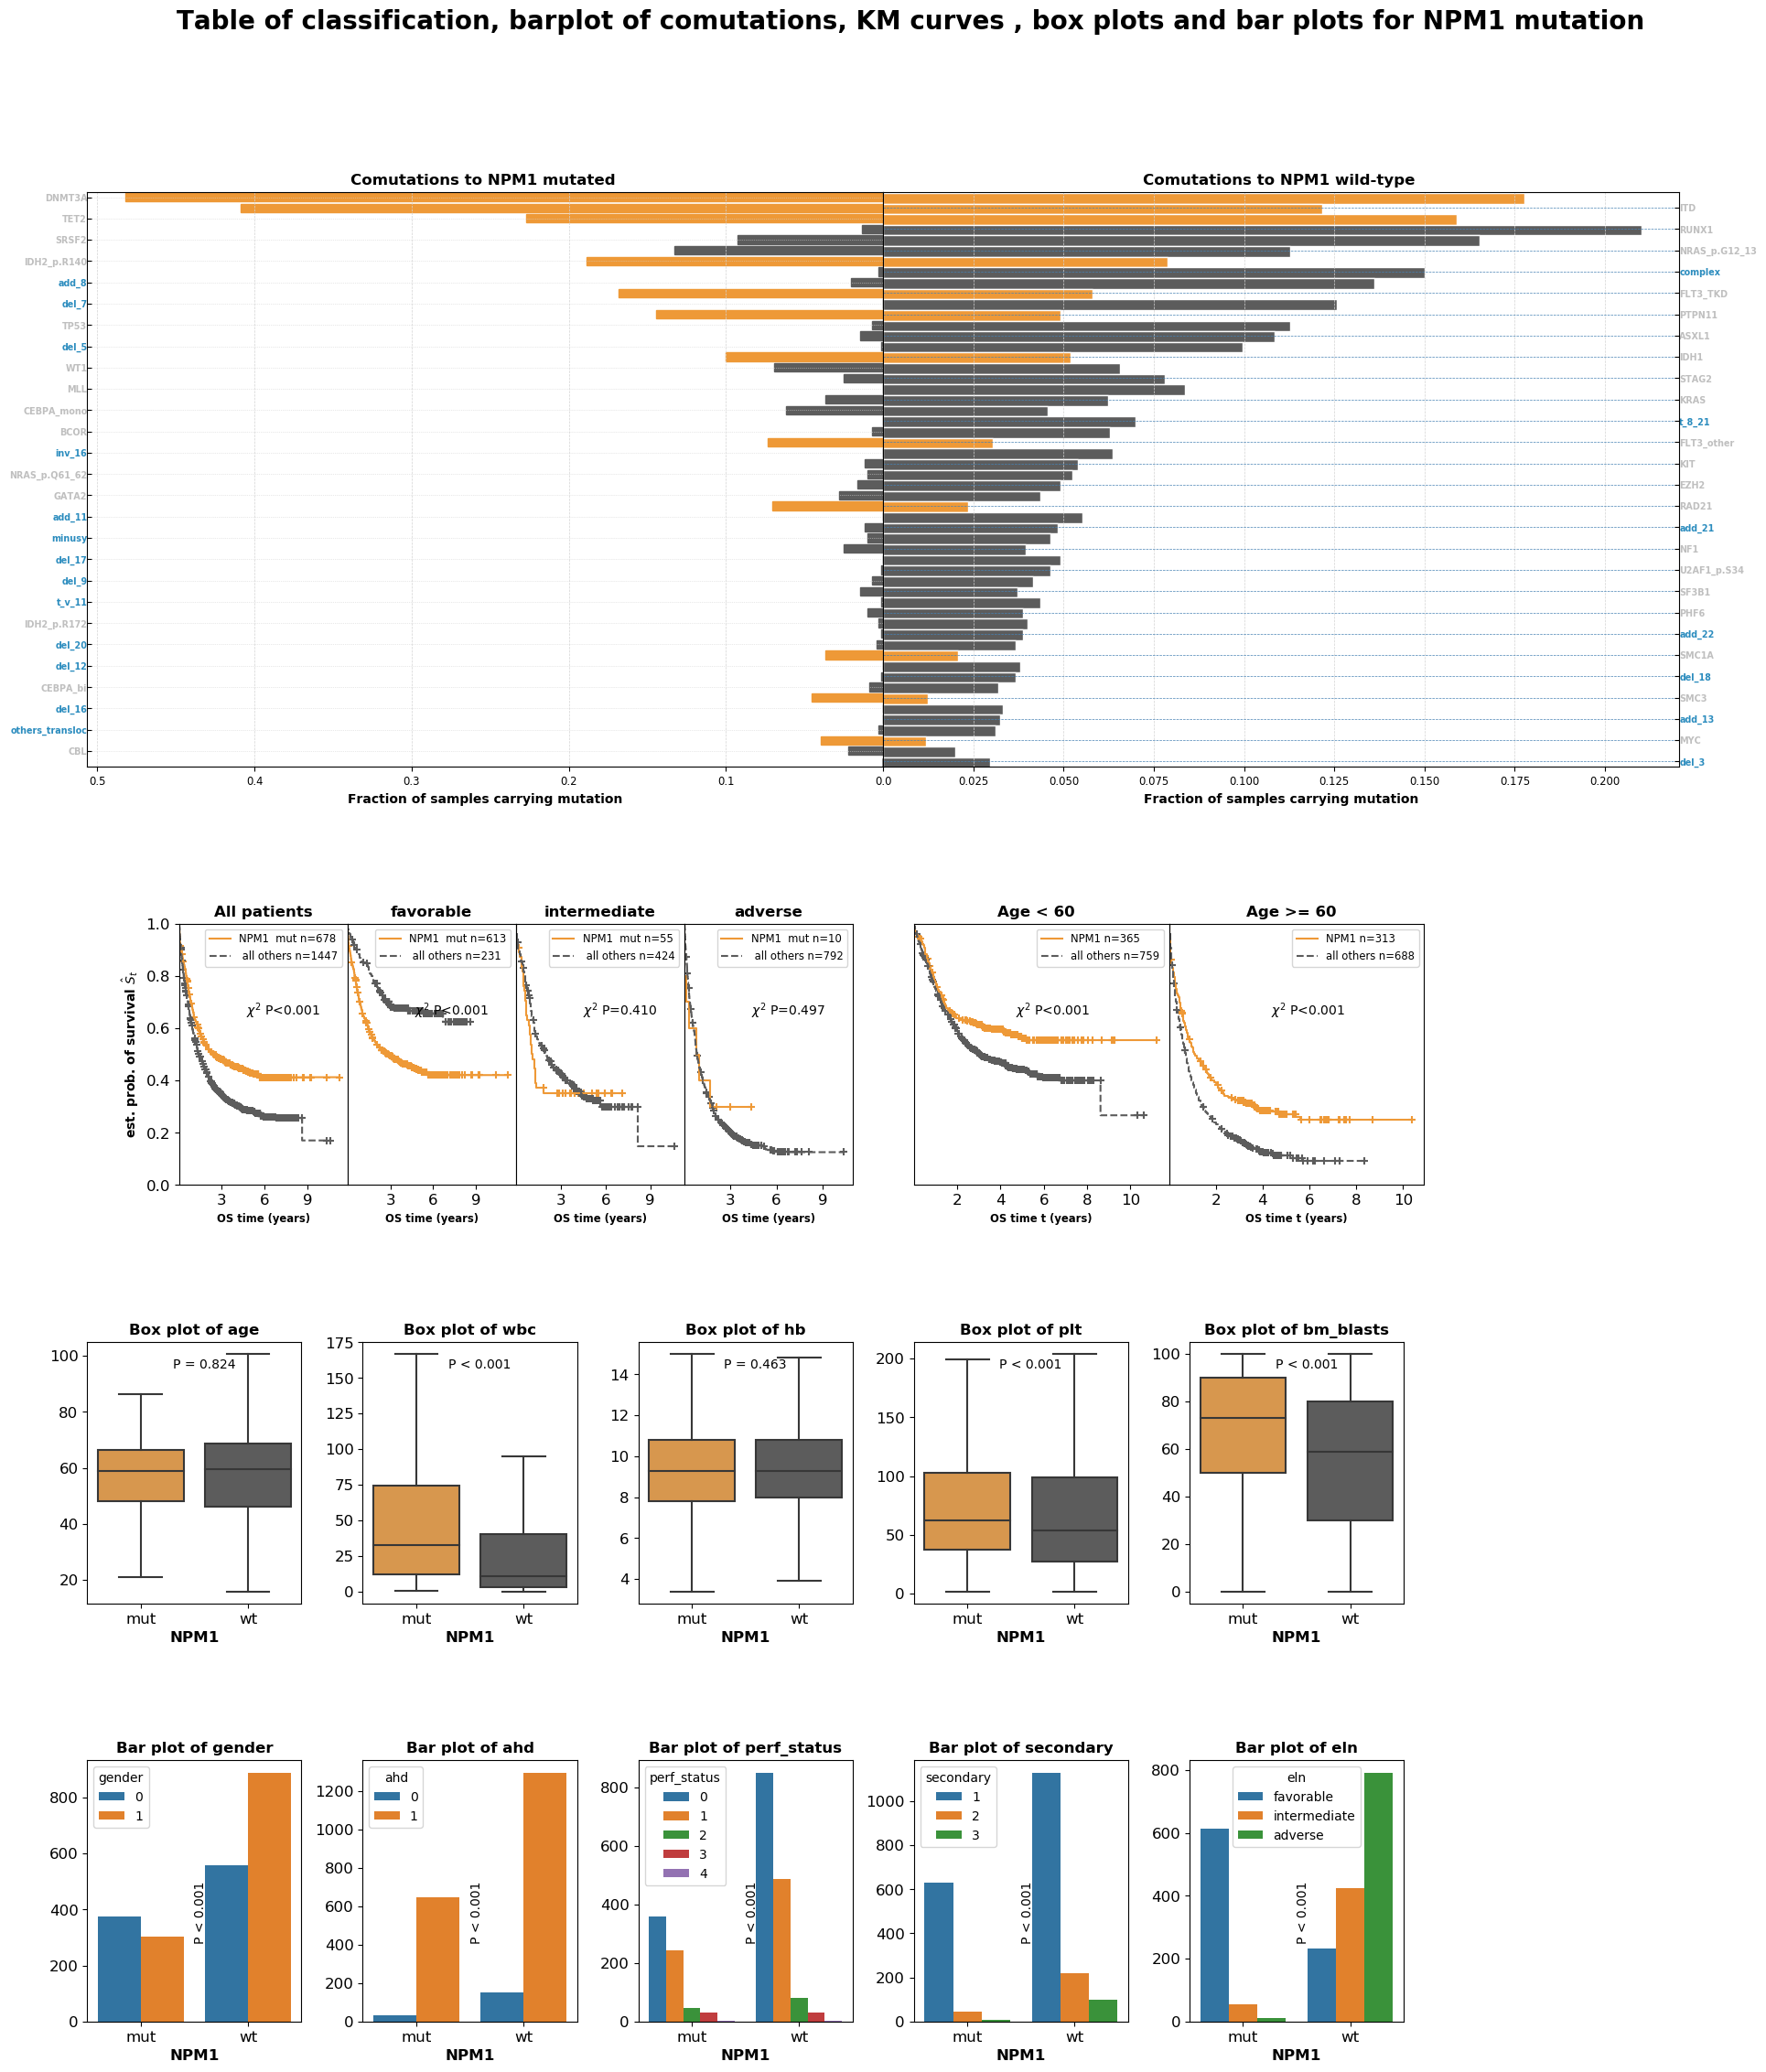

In [13]:
eln_classes = ['favorable', 'intermediate', 'adverse']
molecular_classes = [c for c in df.columns if ( c.startswith( 'full' ))]
genes_order = df.loc[:, gene_freq_cols+cyto_freq_cols].sum(axis=0).sort_values(ascending=False).index
genet=["NPM1"]
for gene_col in genet:
    fig = plt.figure(figsize=(20,25))
    outer = gridspec.GridSpec(nrows=18, ncols=18)

    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[:6,:])
    ax_inner = plt.Subplot(fig, inner[0])
##=======================================================================================================================   Table
#     cell_text = []
    
#     for row_label in eln_classes:
#         row = []
#         n_mut_class  = df.loc[(df[gene_col]==1)&(df.eln==row_label)].shape[0]
#         n_mut = df.loc[df[gene_col]==1].shape[0]

#         if n_mut_class==0:
#             row.append('%d'%n_mut_class)
#             row.append('')
#         else:
#             row.append('%d'%n_mut_class)
#             row.append('%.2f %%'%(n_mut_class*100/n_mut))

#         cell_text.append(row)
    
#     row = []
#     n_mut = df.loc[df[gene_col]==1].shape[0]

#     n = df.shape[0]
#     row.append('%d'%n_mut)
#     row.append('%.2f %%' % (n_mut * 100 / n))
    
#     cell_text.append(row)
    
#     for row_label in molecular_classes:
#         row = []
#         n_mut_class = df.loc[(df[gene_col] == 1) & (df[row_label] == 1)].shape[0]
#         n_mut = df.loc[df[gene_col] == 1].shape[0]

#         if n_mut_class==0:
#             row.append('%d'%n_mut_class)
#             row.append('')
#         else:
#             row.append('%d'%n_mut_class)
#             row.append('%.2f %%'%(n_mut_class*100/n_mut))

#         cell_text.append(row)
        
#     row = []
#     n_mut = df.loc[df[gene_col]==1].shape[0]

#     n = df.shape[0]
#     row.append('%d'%n_mut)
#     row.append('%.2f %%' % (n_mut * 100 / n))

#     cell_text.append(row)
    
#     table = ax_inner.table(cellText=cell_text,
#                            cellLoc='center',
#                            rowLabels=eln_classes+['total']+molecular_classes+['total'],
#                            colLabels=['Mutated %s' % gene_col,'Percentage'],
#                            loc='center',
#                            bbox=[0.2, 0, 0.75, 1.0])

#     table_props = table.properties()
#     table_cells = table_props['child_artists']
    
#     for i in range(0,2):
#         table.get_celld()[(0, i)].set_text_props(fontweight='bold', fontsize='x-large')

#     for i in range(1,len(df.final_component.unique())+6):
#         table.get_celld()[(i,-1)].set_text_props(fontweight='bold', fontsize='large')

#     for i in [4, len(df.final_component.unique())+5]:
#         for j in [-1,0,1]:
#             table.get_celld()[(i,j)].set_facecolor('lightgray')

#     for i,cell in enumerate(table_cells):
#         cell.set_height(0.1)
#         cell.set_width(0.2)
#         i +=1

#     ax_inner.axis('off')
#     fig.add_subplot(ax_inner)
##=======================================================================================================================   End Table
    #Remove root gene when gene col is a hotspot
##=======================================================================================================================   Comutations   
    if gene_col in gene_freq_cols:
        gene_root = gene_col.split('_')[0]
        gene_hotspots = [x for x in genes_order if x.startswith(gene_root)]
        #if gene_root == gene_col:
        df_comutations = df.loc[df[gene_col] == 1].loc[:, genes_order].sum(axis=0).drop(gene_hotspots, axis=0).to_frame()
        df_comutations = pd.concat([df_comutations, df.loc[df[gene_col] == 0].loc[:, genes_order].sum(axis=0).drop(gene_hotspots, axis=0).to_frame()], axis=1)
       # else:
            #df_comutations = df.loc[df[gene_col] == 1].loc[:, genes_order].sum(axis=0).drop([gene_col, gene_root], axis=0).to_frame()
            #df_comutations = pd.concat([df_comutations, df.loc[df[gene_col] == 0].loc[:, genes_order].sum(axis=0).drop([gene_col, gene_root], axis=0).to_frame()], axis=1)

    else:
        df_comutations = df.loc[df[gene_col] == 1].loc[:, genes_order].sum(axis=0).drop([gene_col]).to_frame()
        df_comutations = pd.concat([df_comutations, df.loc[df[gene_col] == 0].loc[:, genes_order].sum(axis=0).drop([gene_col]).to_frame()], axis=1)

    df_comutations.columns = ['mut','wt']
    df_comutations = df_comutations.loc[(df_comutations.wt!=0) | (df_comutations.mut!=0)]

    n_mut = df.loc[df[gene_col]==1].shape[0]
    n_wt = df.loc[df[gene_col]==0].shape[0]
    df_comutations.loc[:,'mut'] = df_comutations.loc[:, 'mut']/n_mut
    df_comutations.loc[:, 'wt'] = df_comutations.loc[:, 'wt'] / n_wt

    df_comutations = df_comutations.reset_index()
    df_comutations.columns = ['gene', 'mut', 'wt']
    df_comutations.gene = df_comutations.gene.astype('category')
    df_comutations.gene.cat.set_categories(genes_order, inplace=True)
    df_comutations.sort_values(['gene'], inplace=True)
    df_comutations.gene = df_comutations.gene.astype('str')
    df_comutations.set_index(['gene'], inplace=True)

    del df_comutations.index.name
    #inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:6, 7:],wspace=0)
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:6, :],wspace=0)
    ax_inner = plt.Subplot(fig, inner[0])

    g = sns.barplot(x=df_comutations.mut, y=df_comutations.index,ax=ax_inner)
    threshold = 0.05
    p_values = []
    oddsratios = []

    gene_cyto =[]
    list_cyto = []
    for gene_comut in df_comutations.index:
        wt_wt = df[(df[gene_col]==0) & (df[gene_comut]==0)].shape[0]
        wt_mut = df[(df[gene_col]==0) & (df[gene_comut] == 1)].shape[0]
        mut_wt = df[(df[gene_col]==1) & (df[gene_comut] == 0)].shape[0]
        mut_mut = df[(df[gene_col]==1) & (df[gene_comut] == 1)].shape[0]

        oddsratio,p_value = fisher_exact(table=[[wt_wt, wt_mut], [mut_wt, mut_mut]], alternative='two-sided')
        p_values.append(p_value)
        oddsratios.append(oddsratio)

    rej, p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    list_associated = []
    list_exclusive = []
    for i, gene_comut in enumerate(df_comutations.index):
        if (p_values[i] < 0.05) & (oddsratios[i] > 1):
            list_associated.append(gene_comut)
        if (p_values[i] < 0.05) & (oddsratios[i] < 1):
            list_exclusive.append(gene_comut)
        if(gene_comut in cyto_freq_cols):
            gene_cyto.append("cyto")
        else:
            gene_cyto.append("gene")
        if gene_comut in cyto_freq_cols:
            list_cyto.append(gene_comut)



    for idx,b in enumerate(g.patches):
        b.set_color("#5C5C5C")
        
        p_value = p_values[idx]
        oddsratio = oddsratios[idx]

        if p_value < threshold:
            if oddsratio < 1:
                b.set_color('#5C5C5C')
            else:
                b.set_color('#EE9937')



    b.set_edgecolor(color='white')
    b.set_height(1.0)

    g.invert_xaxis()
    g.set_xlabel('Fraction of samples carrying mutation', fontsize='medium', fontweight='bold')

    major_ticks = np.arange(0, df_comutations.shape[0], 2)
    minor_ticks = np.arange(1, df_comutations.shape[0], 2)

    g.set_yticks(major_ticks)
    g.set_yticks(minor_ticks, minor = True)
    g.tick_params(axis = 'y', which = 'major', direction='in', pad=0)
    g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
    g.set_yticklabels(labels=df_comutations.index.values[::2],fontsize='x-small', fontweight='bold')

    for tick in g.get_yaxis().get_majorticklabels():
        tick.set_ha('right')

    for tick in g.get_xaxis().get_majorticklabels():
        tick.set_fontsize('small')

    g.yaxis.tick_left()
    g.yaxis.grid(color='lightgray', linestyle=':', linewidth=0.5)
    g.xaxis.grid(color='lightgray',linestyle='--',linewidth=0.5)

    for tick in g.get_yaxis().get_majorticklabels():
        tick.set_color("#BFBFBF")
        if tick.get_text() in list_cyto:
            tick.set_color('#2b8cbe')


    if gene_col in gene_freq_cols:
        g.set_title('Comutations to %s mutated '%gene_col, fontsize='large', fontweight='bold')
    else:
        g.set_title('Comutations to %s ' % gene_col, fontsize='large', fontweight='bold')
    fig.add_subplot(ax_inner)

    ax_inner = plt.Subplot(fig, inner[1])

    g = sns.barplot(x=df_comutations.wt, y=df_comutations.index,ax=ax_inner)

    for idx,b in enumerate(g.patches):
        b.set_color("#5C5C5C")
        
        p_value = p_values[idx]
        oddsratio = oddsratios[idx]

        if p_value < threshold:
            if oddsratio < 1:
                b.set_color('#5C5C5C')
            else:
                b.set_color('#EE9937')

        b.set_edgecolor(color='white')
        b.set_height(1.0)


    g.set_xlabel('Fraction of samples carrying mutation', fontsize='medium', fontweight='bold')
    g.xaxis.set_major_locator(MaxNLocator(prune='lower'))

    major_ticks = np.arange(1, df_comutations.shape[0], 2)
    minor_ticks = np.arange(0, df_comutations.shape[0], 2)

    g.set_yticks(major_ticks)
    g.set_yticks(minor_ticks, minor = True)
    g.tick_params(axis = 'y', which = 'major', direction='in', pad=0)
    g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
    g.set_yticklabels(labels=df_comutations.index.values[1::2],fontsize='x-small', fontweight='bold')

    for tick in g.get_xaxis().get_majorticklabels():
        tick.set_fontsize('small')

    g.yaxis.tick_right()
    g.yaxis.grid(color='steelblue', linestyle='--', linewidth=0.5)
    g.xaxis.grid(color='lightgray',linestyle='--',linewidth=0.5)

    for tick in g.get_yaxis().get_majorticklabels():
        tick.set_color("#BFBFBF")
        if tick.get_text() in list_cyto:
            tick.set_color('#2b8cbe')
            
    if gene_col in gene_freq_cols:
        g.set_title('Comutations to %s wild-type ' % gene_col, fontsize='large', fontweight='bold')
    else:
        g.set_title('Comutations to not %s ' % gene_col, fontsize='large', fontweight='bold')
    fig.add_subplot(ax_inner)
    ##=======================================================================================================================   Surv Plots
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[7:10,1:9],wspace=0)

    for j, eln_class in enumerate(["All patients"]+eln_classes):
        ax_inner = plt.Subplot(fig, inner[j])
        if eln_class =="All patients":
            df_other = df.loc[df[gene_col]==0]
            df_slct = df.loc[df[gene_col]==1]
        else:
            df_other = df.loc[(df.eln==eln_class) & (df[gene_col]==0)]
            df_slct = df.loc[(df.eln==eln_class) & (df[gene_col]==1)]

        plot_compare_km(dataframes=[df_slct,df_other],
                        labels=['%s  mut' % (gene_col), ' all others' ],
                        mask_labels=[eln_class, eln_class],
                        ax=ax_inner,
                        colors=["#EE9937","#5C5C5C"],
                        linestyles=['-','--'],
                        label_legend='dataset',
                        test_statistic='CMH_logrank',
                        xy_statistic=(0.4, 0.65),
                        font_size_statistic='medium')

        if j==0:
            ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
        else:
            ax_inner.set_yticks([])
        ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
        ax_inner.set_xlim(left=0.)
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
        ax_inner.set_ylim([0.,1.])
        ax_inner.legend(loc='upper right', fontsize='small')
        ax_inner.set_title(eln_class, fontsize='large', fontweight='bold')

        fig.add_subplot(ax_inner)
     
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[7:10,9:],wspace=0)
    
    for i, title in enumerate(['Age < 60 ', 'Age >= 60 ']):
        ax_inner = plt.Subplot(fig, inner[i])
        if title == 'Age < 60 ':
            df_other = df.loc[(df.age < 60) & (df[gene_col]==0)]
            df_slct = df.loc[(df.age < 60) & (df[gene_col]==1)]
        else:
            df_other = df.loc[(df.age >= 60) & (df[gene_col]==0)]
            df_slct = df.loc[(df.age >= 60) & (df[gene_col]==1)]


        plot_compare_km(dataframes=[df_slct, df_other],
                        labels=[gene_col, 'all others' ],
                        mask_labels=[title, title],
                        ax=ax_inner,
                        colors=["#EE9937","#5C5C5C"],
                        linestyles=['-', '--'],
                        label_legend='dataset',
                        test_statistic='CMH_logrank',
                        xy_statistic=(0.4, 0.65),
                        font_size_statistic='medium')


        ax_inner.set_yticks([])
        ax_inner.set_xlabel('OS time t (years)', fontsize='small', fontweight='bold')
        ax_inner.set_xlim(left=0.)
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=7, prune='lower', integer=True))
        ax_inner.set_ylim([0., 1.])
        ax_inner.legend(loc='upper right', fontsize='small')
        ax_inner.set_title("%s " % (title), fontsize='large', fontweight='bold')
        
        fig.add_subplot(ax_inner)
##======================================================================================================================= End Surv Plots

##=======================================================================================================================   Continuous Variables
    for i,cont in enumerate(["age","wbc","hb","plt","bm_blasts"]):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[11:14,3*i:3*(i+1)])
        ax_inner = plt.Subplot(fig, inner[0])
        df_slct = df.loc[:,[gene_col]+[cont]]
        df_slct.loc[:,gene_col] = df_slct.loc[:,gene_col].map({0:'wt',1:'mut'})

        statistic, p_value = ranksums(df_slct.loc[df_slct[gene_col]=='wt',cont].dropna().values,df_slct.loc[df_slct[gene_col]=='mut',cont].dropna().values)
        if p_value<0.001:
            s='P < 0.001'
        else:
            s='P = %.3f'%p_value

        ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='medium')
        sns.boxplot(x=gene_col,y=cont,data=df_slct,ax=ax_inner,showfliers=False,palette= ["#EE9937","#5C5C5C"])
        ax_inner.set_title('Box plot of '+cont,fontsize='large',fontweight='bold')
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.set_ylabel('', fontweight='bold')
        ax_inner.set_xlabel('%s' % gene_col, fontsize='large', fontweight='bold')
        fig.add_subplot(ax_inner)


    
##=======================================================================================================================   End Continuous Variables

##=======================================================================================================================    Categorical Variables
    for i,categ in enumerate(["gender","ahd","perf_status","secondary","eln"]):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[15:,3*i:3*(i+1)])
        ax_inner = plt.Subplot(fig, inner[0])
        df_slct = df.loc[:,[gene_col]+[categ]]
        df_slct.loc[:,gene_col] = df_slct.loc[:,gene_col].map({0:'wt',1:'mut'})

        statistic, p_value = ranksums(df_slct.loc[df_slct[gene_col]=='wt',categ].dropna().values,df_slct.loc[df_slct[gene_col]=='mut',categ].dropna().values)
        if p_value<0.05:
            s='P < 0.001'
        else:
            s='P = %.3f'%p_value


        ax_inner.annotate(s=s, xy=(0.5,0.5),rotation=90, xycoords='axes fraction', fontsize='medium')
        sns.countplot(x=gene_col,hue=categ,data=df_slct,ax=ax_inner)
        ax_inner.set_title('Bar plot of '+categ,fontsize='large',fontweight='bold')
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.set_ylabel('', fontsize='small', fontweight='bold')
        ax_inner.set_xlabel('%s' % gene_col, fontsize='large', fontweight='bold')
        fig.add_subplot(ax_inner)
    
    
    
    fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.90, wspace=2, hspace=1)
    if gene_col in gene_freq_cols:
        fig.suptitle('Table of classification, barplot of comutations, KM curves , box plots and bar plots for %s mutation' % gene_col,
                     fontsize='20',fontweight='bold')
    else:
        fig.suptitle('Table of classification, barplot of comutations, KM curves , box plots and bar plots for %s' % gene_col,
                     fontsize='20', fontweight='bold')
#     fig.savefig('graphs/summary_genes/summary_%s.png' % gene_col, format='png')
    fig.savefig('graphs/summary_genes/summary_%s.pdf' % gene_col, format='pdf')
    
    # Display only the first plot in the notebook
    if gene_col in genet:
      plt.show(fig)
    else:
      plt.close(fig)
    

# By Full Component

full_component_t_15_17 2104 21
0 patient for dataset t_15_17 and mask favorable
Patients for dataset t_15_17 and mask Age >= 60 are all censored
full_component_inv_16 2033 92
0 patient for dataset inv_16 and mask intermediate
full_component_t_8_21 2024 101
0 patient for dataset t_8_21 and mask intermediate
full_component_t_11 2031 94
full_component_t_6_9 2108 17
0 patient for dataset t_6_9 and mask favorable
0 patient for dataset t_6_9 and mask intermediate
full_component_inv_3 2104 21
0 patient for dataset inv_3 and mask favorable
0 patient for dataset inv_3 and mask intermediate
full_component_additions 1916 209
0 patient for dataset additions and mask favorable
full_component_TP53_complex 1880 245
0 patient for dataset TP53_complex and mask favorable
full_component_NPM1 1447 678
full_component_CEBPA_bi 2073 52
0 patient for dataset CEBPA_bi and mask intermediate
0 patient for dataset CEBPA_bi and mask adverse
full_component_DNMT3A_IDH1_2 2024 101
0 patient for dataset DNMT3A_IDH1_2 

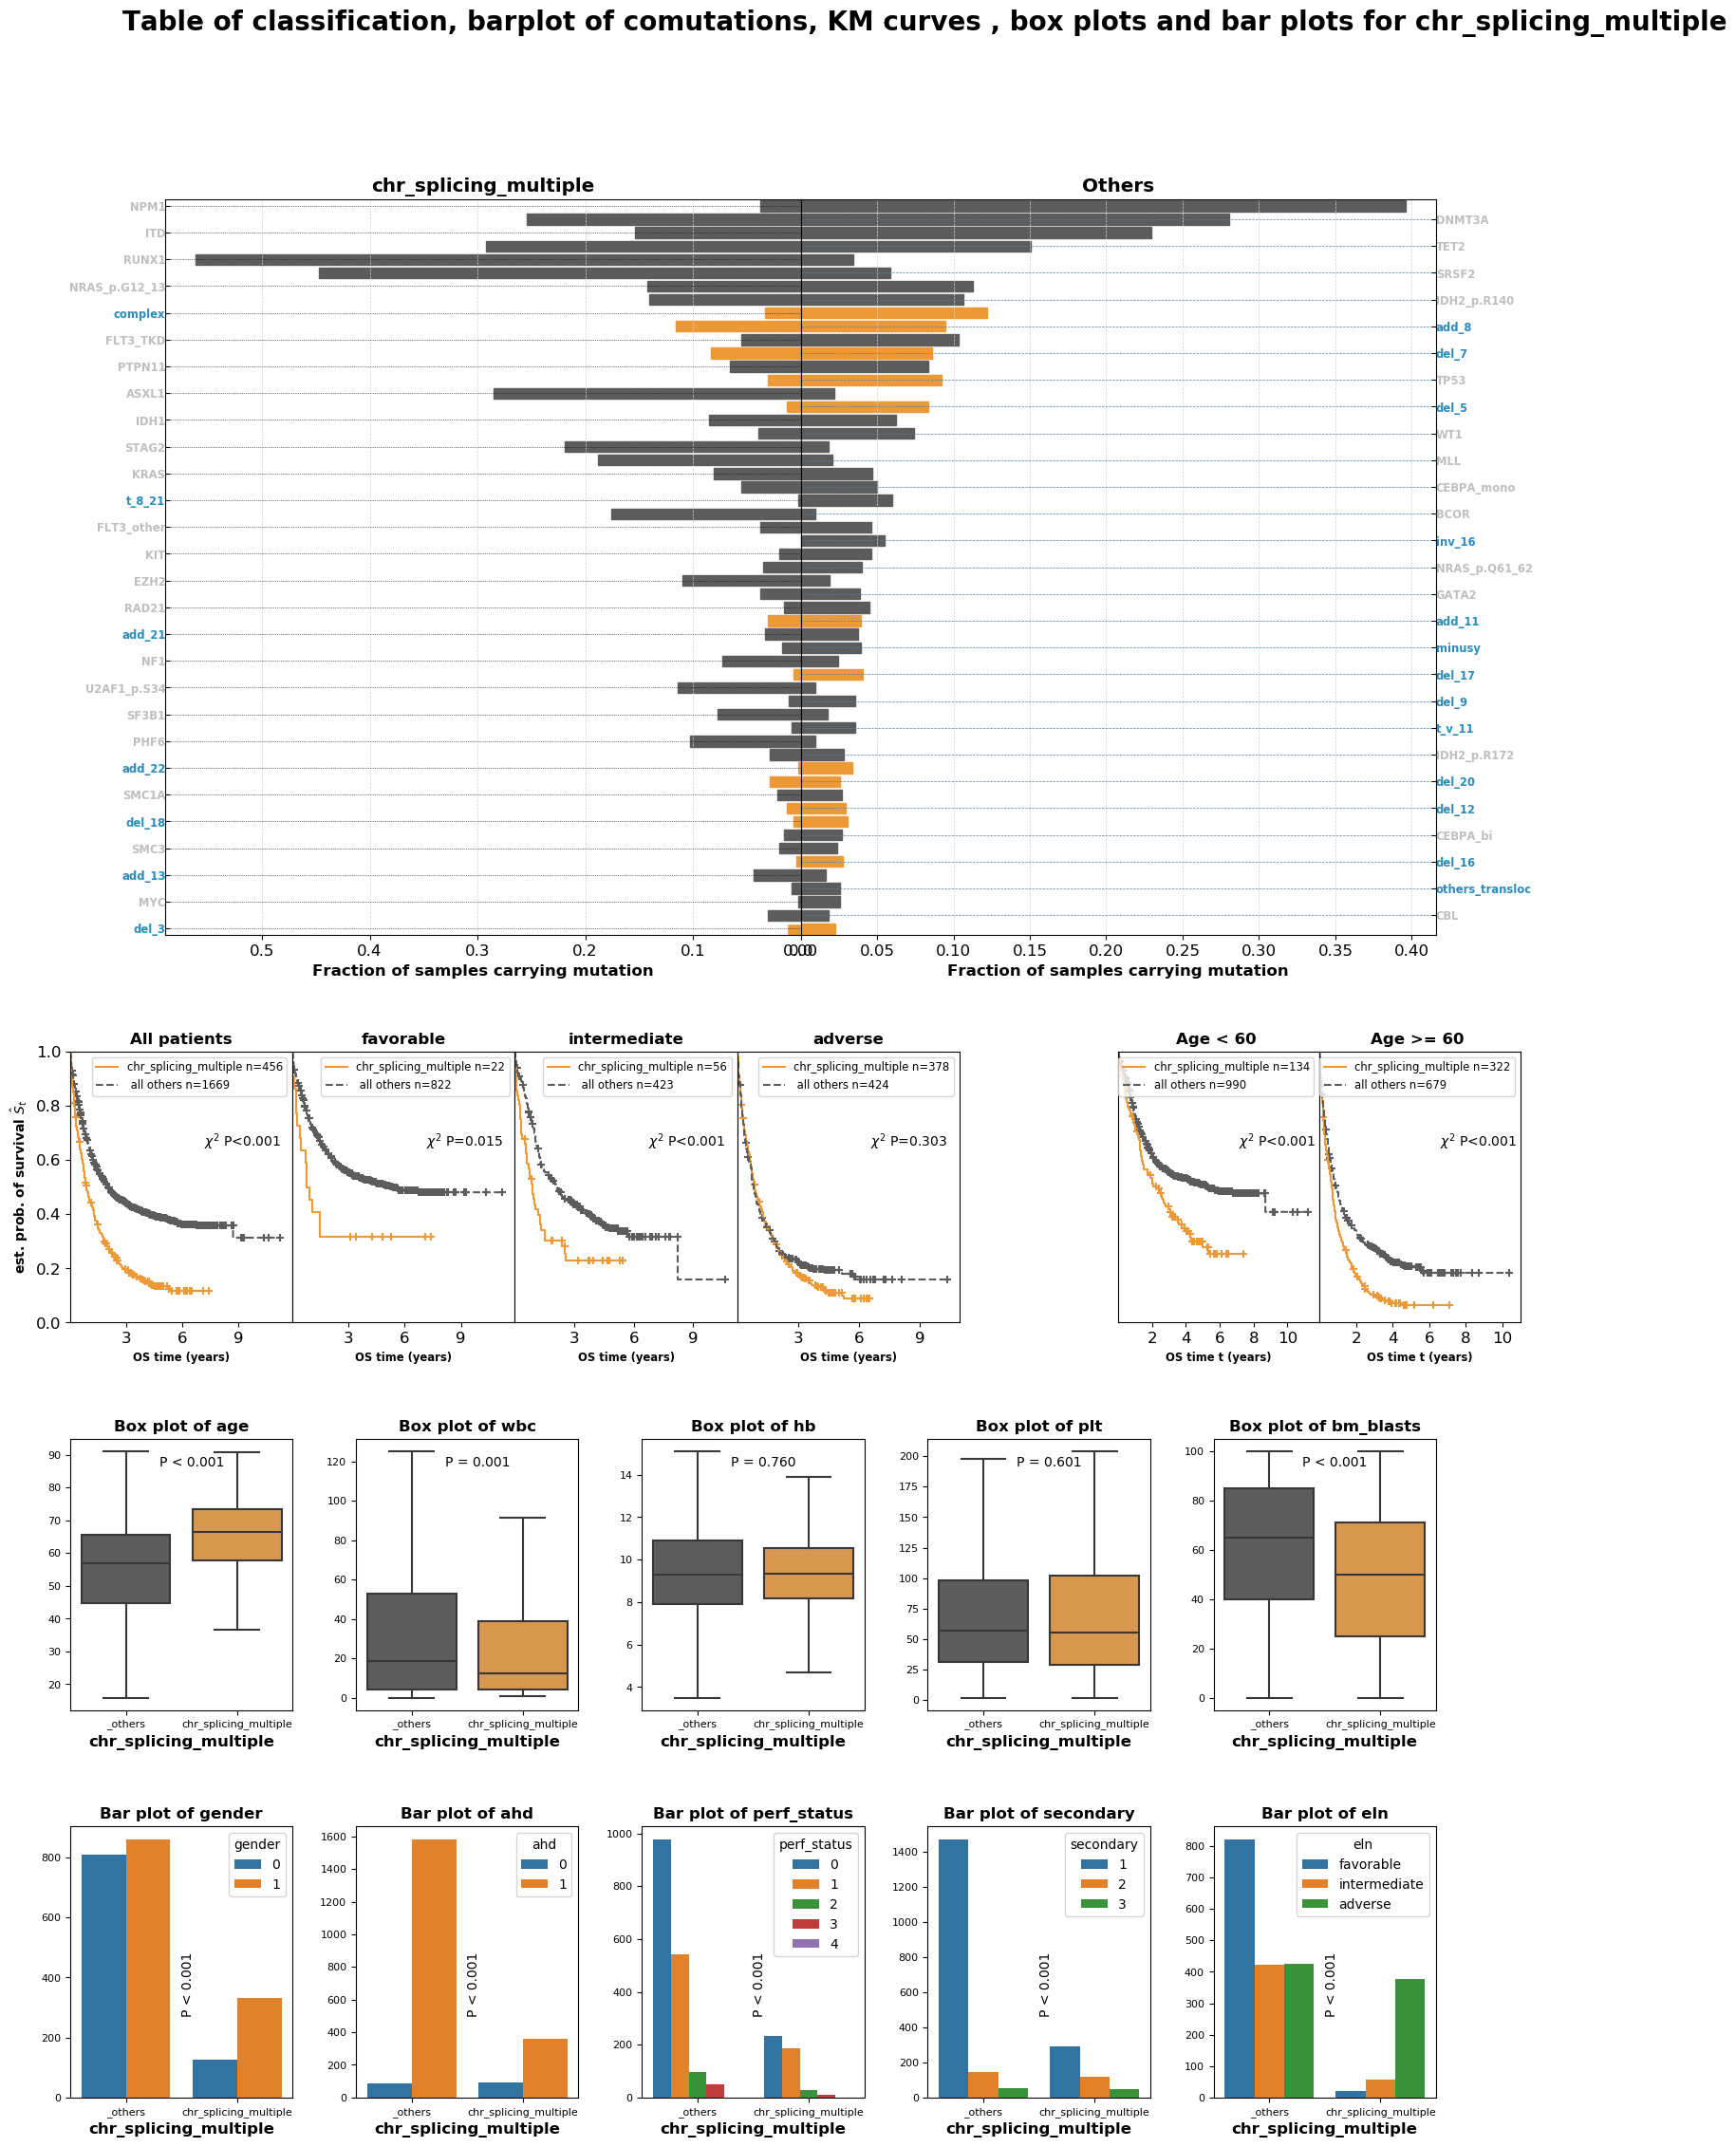

full_component_chr_splicing_1 1942 183
0 patient for dataset chr_splicing_1 and mask favorable
full_component_not_assigned 2004 121
0 patient for dataset not_assigned and mask favorable
full_component_no_events 2074 51
0 patient for dataset no_events and mask favorable
Patients for dataset no_events and mask adverse are all censored


In [36]:
plt.style.use('default')
comp_cols= [col for col in df if (col.startswith('full_component_'))]
# comp_cols=['full_component_chr_splicing_multiple']
for comp in comp_cols:
    fig = plt.figure(figsize=(20,25))
    outer = gridspec.GridSpec(nrows=25, ncols=18)
##=======================================================================================================================   Table    
#     inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[2:9,12:17])
#     ax_inner = plt.Subplot(fig, inner[0])

#     cell_text = []
    
#     for row_label in eln_classes:
#         row = []
#         n_comp_class  = df.loc[(df[comp]==1)&(df.eln==row_label)].shape[0]
#         n_comp = df.loc[df[comp]==1].shape[0]
#         if n_comp_class==0:
#             row.append('%d'%n_comp_class)
#             row.append('')
#         else:
#             row.append('%d'%n_comp_class)
#             row.append('%.2f %%'%(n_comp_class*100/n_comp))

#         cell_text.append(row)
    
#     row = []
#     n_comp = df.loc[df[comp]==1].shape[0]

#     n = df.shape[0]
#     row.append('%d'%n_comp)
#     row.append('%.2f %%' % (n_comp * 100 / n))
    
#     cell_text.append(row)
    
#     table = ax_inner.table(cellText=cell_text,
#                            cellLoc='center',
#                            rowLabels=eln_classes+['total'],
#                            colLabels=[comp,'Percentage'],
#                            loc='center',
#                            bbox=[0.2, 0, 0.75, 1.0])

#     table_props = table.properties()
#     #table_cells = table_props['child_artists']
    
#     for i in range(0,2):
#         table.get_celld()[(0, i)].set_text_props(fontweight='bold', fontsize='x-large')

#     for i in range(1,5):
#         table.get_celld()[(i,-1)].set_text_props(fontweight='bold', fontsize='large')

#     for i in [4]:
#         for j in [-1,0,1]:
#             table.get_celld()[(i,j)].set_facecolor('lightgray')

#     for i,cell in enumerate(table_cells):
#         cell.set_height(0.1)
#         cell.set_width(0.2)
#         i +=1

    
#     ax_inner.axis('off')
#     fig.add_subplot(ax_inner)
##======================================================================================================================= Plot comutations
    df_comutations = df.groupby(comp).sum()[genes_order].T
    df_comutations.columns = ['others',comp.replace('full_component_','')]

    others = df.loc[df[comp] == 0].shape[0]
    target = df.loc[df[comp] == 1].shape[0]
    print(comp,others,target)
    df_comutations.loc[:,'others' ] = df_comutations.loc[:, 'others']/others
    df_comutations.loc[:, comp.replace('full_component_','')] = df_comutations.loc[:, comp.replace('full_component_','')]/target

    df_comutations = df_comutations.reset_index()
    df_comutations.columns = ['gene', 'others', comp.replace('full_component_','')]
    df_comutations.gene = df_comutations.gene.astype('category')
    df_comutations.gene.cat.set_categories(genes_order, inplace=True)
    df_comutations.sort_values(['gene'], inplace=True)
    df_comutations.gene = df_comutations.gene.astype('str')
    df_comutations.set_index(['gene'],inplace=True)

    del df_comutations.index.name

    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:10, 1:15],wspace=0)
    ax_inner = plt.Subplot(fig, inner[0])
    g = sns.barplot(x=df_comutations[comp.replace('full_component_','')], y=df_comutations.index,ax=ax_inner)
    
    threshold = 0.05
    p_values = []
    oddsratios = []

    gene_cyto =[]
    list_cyto = []
    for gene_comut in df_comutations.index:
        wt_wt = df[(df[gene_col]==0) & (df[gene_comut]==0)].shape[0]
        wt_mut = df[(df[gene_col]==0) & (df[gene_comut] == 1)].shape[0]
        mut_wt = df[(df[gene_col]==1) & (df[gene_comut] == 0)].shape[0]
        mut_mut = df[(df[gene_col]==1) & (df[gene_comut] == 1)].shape[0]

        oddsratio,p_value = fisher_exact(table=[[wt_wt, wt_mut], [mut_wt, mut_mut]], alternative='two-sided')
        p_values.append(p_value)
        oddsratios.append(oddsratio)

    rej, p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    list_associated = []
    list_exclusive = []
    for i, gene_comut in enumerate(df_comutations.index):
        if (p_values[i] < 0.05) & (oddsratios[i] > 1):
            list_associated.append(gene_comut)
        if (p_values[i] < 0.05) & (oddsratios[i] < 1):
            list_exclusive.append(gene_comut)
        if(gene_comut in cyto_freq_cols):
            gene_cyto.append("cyto")
        else:
            gene_cyto.append("gene")
        if gene_comut in cyto_freq_cols:
            list_cyto.append(gene_comut)



    for idx,b in enumerate(g.patches):
        b.set_color("#5C5C5C")
        
        p_value = p_values[idx]
        oddsratio = oddsratios[idx]

        if p_value < threshold:
            if oddsratio < 1:
                b.set_color('#5C5C5C')
            else:
                b.set_color('#EE9937')



    b.set_edgecolor(color='white')
    b.set_height(1.0)

    g.invert_xaxis()
    g.set_xlabel('Fraction of samples carrying mutation', fontsize='large', fontweight='bold')

    major_ticks = np.arange(0, df_comutations.shape[0], 2)
    minor_ticks = np.arange(1, df_comutations.shape[0], 2)

    g.set_yticks(major_ticks)
    g.set_yticks(minor_ticks, minor = True)
    g.tick_params(axis = 'y', which = 'major', direction='in', pad=0)
    g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
    g.set_yticklabels(labels=df_comutations.index.values[::2],fontsize='small', fontweight='bold')

    for tick in g.get_yaxis().get_majorticklabels():
        tick.set_color("#BFBFBF")
        if tick.get_text() in list_cyto:
            tick.set_color('#2b8cbe')

    for tick in g.get_xaxis().get_majorticklabels():
        tick.set_fontsize('large')

    g.yaxis.tick_left()
    g.yaxis.grid(color='black', linestyle=':', linewidth=0.5)
    g.xaxis.grid(color='lightgray',linestyle='--', linewidth=0.5)
    g.set_title(comp.replace('full_component_',''), fontsize='x-large', fontweight='bold')
    fig.add_subplot(ax_inner)

    ax_inner = plt.Subplot(fig, inner[1])
    g = sns.barplot(x=df_comutations['others'], y=df_comutations.index, ax=ax_inner)

    for idx,b in enumerate(g.patches):
        b.set_color("#5C5C5C")
        
        p_value = p_values[idx]
        oddsratio = oddsratios[idx]

        if p_value < threshold:
            if oddsratio < 1:
                b.set_color('#5C5C5C')
            else:
                b.set_color('#EE9937')

    g.set_xlabel('Fraction of samples carrying mutation', fontsize='large', fontweight='bold')
    major_ticks = np.arange(1, df_comutations.shape[0], 2)
    minor_ticks = np.arange(0, df_comutations.shape[0], 2)

    g.set_yticks(major_ticks)
    g.set_yticks(minor_ticks, minor = True)
    g.tick_params(axis='y', which='major', direction='in', pad=0)
    g.tick_params(axis='y', which='minor', labelsize=0, length=0)
    g.set_yticklabels(labels=df_comutations.index.values[1::2], fontsize='small', fontweight='bold')

    for tick in g.get_xaxis().get_majorticklabels():
        tick.set_fontsize('large')

    g.yaxis.tick_right()
    g.yaxis.grid(color='steelblue', linestyle='--', linewidth=0.5)
    g.xaxis.grid(color='lightgray', linestyle='--', linewidth=0.5)

    for tick in g.get_yaxis().get_majorticklabels():
        tick.set_color("#BFBFBF")
        if tick.get_text() in list_cyto:
            tick.set_color('#2b8cbe')

    g.set_title('Others', fontsize='x-large', fontweight='bold')
    fig.add_subplot(ax_inner)

 ##======================================================================================================================= End Comutations   
 ##======================================================================================================================= Plot Survivals  
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[11:15,:10],wspace=0)

    for j, eln_class in enumerate(["All patients"]+eln_classes):
        ax_inner = plt.Subplot(fig, inner[j])
        if eln_class =="All patients":
            df_other = df.loc[df[comp]==0]
            df_slct = df.loc[df[comp]==1]
        else:
            df_other = df.loc[(df.eln==eln_class) & (df[comp]==0)]
            df_slct = df.loc[(df.eln==eln_class) & (df[comp]==1)]

        plot_compare_km(dataframes=[df_slct,df_other],
                        labels=[comp.replace('full_component_',''), ' all others' ],
                        mask_labels=[eln_class, eln_class],
                        ax=ax_inner,
                        #colors=sns.color_palette()[:2],
                        colors= ["#EE9937","#5C5C5C"],
                        linestyles=['-','--'],
                        label_legend='dataset',
                        test_statistic='CMH_logrank',
                        xy_statistic=(0.6, 0.65),
                        font_size_statistic='medium')

        if j==0:
            ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
        else:
            ax_inner.set_yticks([])
        ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
        ax_inner.set_xlim(left=0.)
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
        ax_inner.set_ylim([0.,1.])
        ax_inner.legend(loc='upper right', fontsize='small')
        ax_inner.set_title(eln_class, fontsize='large', fontweight='bold')

        fig.add_subplot(ax_inner)
     
    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[11:15,11:20],wspace=0)
    
    for i, title in enumerate(['Age < 60', 'Age >= 60']):
        ax_inner = plt.Subplot(fig, inner[i])
        if title == 'Age < 60':
            df_other = df.loc[(df.age < 60) & (df[comp]==0)]
            df_slct = df.loc[(df.age < 60) & (df[comp]==1)]
        else:
            df_other = df.loc[(df.age >= 60) & (df[comp]==0)]
            df_slct = df.loc[(df.age >= 60) & (df[comp]==1)]

        plot_compare_km(dataframes=[df_slct, df_other],
                        labels=[comp.replace('full_component_',''), 'all others' ],
                        mask_labels=[title, title],
                        ax=ax_inner,
                        #colors=sns.color_palette()[:2],
                        colors= ["#EE9937","#5C5C5C"],
                        linestyles=['-', '--'],
                        label_legend='dataset',
                        test_statistic='CMH_logrank',
                        xy_statistic=(0.6, 0.65),
                        font_size_statistic='medium')


        ax_inner.set_yticks([])
        ax_inner.set_xlabel('OS time t (years)', fontsize='small', fontweight='bold')
        ax_inner.set_xlim(left=0.)
        ax_inner.tick_params(axis='both', which='major', labelsize=12)
        ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=7, prune='lower', integer=True))
        ax_inner.set_ylim([0., 1.])
        ax_inner.legend(loc='upper right', fontsize='small')
        ax_inner.set_title("%s " % (title), fontsize='large', fontweight='bold')
        
        fig.add_subplot(ax_inner)
  ##======================================================================================================================= End Survivals

##=======================================================================================================================   Continuous Variables
    for i,cont in enumerate(["age","wbc","hb","plt","bm_blasts"]):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[16:20,3*i:3*(i+1)])
        ax_inner = plt.Subplot(fig, inner[0])
        df_slct = df.loc[:,[comp]+[cont]]
        df_slct.loc[:,comp] = df_slct.loc[:,comp].map({0:'_others',1:comp.replace('full_component_','')})

        statistic, p_value = ranksums(df_slct.loc[df_slct[comp]=='_others',cont].dropna().values,df_slct.loc[df_slct[comp]==comp.replace('full_component_',''),cont].dropna().values)
        if p_value<0.001:
            s='P < 0.001'
        else:
            s='P = %.3f'%p_value
        ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='medium')
        sns.boxplot(x=comp,y=cont,data=df_slct,ax=ax_inner,showfliers=False,palette= ["#5C5C5C","#EE9937"])
        ax_inner.set_title('Box plot of '+cont,fontsize='large',fontweight='bold')
        ax_inner.tick_params(axis='both', which='major', labelsize=8)
        ax_inner.set_ylabel('', fontweight='bold')
        ax_inner.set_xlabel(comp.replace('full_component_',''), fontsize='large', fontweight='bold')
        fig.add_subplot(ax_inner)
  ##=======================================================================================================================   End Continuous Variables
##=======================================================================================================================    Categorical Variables
    for i,categ in enumerate(["gender","ahd","perf_status","secondary","eln"]):
        inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[21:,3*i:3*(i+1)])
        ax_inner = plt.Subplot(fig, inner[0])
        df_slct = df.loc[:,[comp]+[categ]]
        df_slct.loc[:,comp] = df_slct.loc[:,comp].map({0:'_others',1:comp.replace('full_component_','')})

        statistic, p_value = ranksums(df_slct.loc[df_slct[comp]=='_others',categ].dropna().values,df_slct.loc[df_slct[comp]==comp.replace('full_component_',''),categ].dropna().values)
        if p_value<0.05:
            s='P < 0.001'
        else:
            s='P = %.3f'%p_value
        ax_inner.annotate(s=s, xy=(0.5,0.5),rotation=90, xycoords='axes fraction', fontsize='medium')
        sns.countplot(x=comp,hue=categ,data=df_slct,ax=ax_inner)
        ax_inner.set_title('Bar plot of '+categ,fontsize='large',fontweight='bold')
        ax_inner.tick_params(axis='both', which='major', labelsize=8)
        ax_inner.set_ylabel('', fontsize='small', fontweight='bold')
        ax_inner.set_xlabel(comp.replace('full_component_',''), fontsize='large', fontweight='bold')
        fig.add_subplot(ax_inner)

    fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.90, wspace=2, hspace=1)
    if gene_col in gene_freq_cols:
        fig.suptitle('Table of classification, barplot of comutations, KM curves , box plots and bar plots for %s ' % comp.replace('full_component_',''),
                     fontsize='20',fontweight='bold')
    else:
        fig.suptitle('Table of classification, barplot of comutations, KM curves , box plots and bar plots for %s' % comp.replace('full_component_',''),
                     fontsize='20', fontweight='bold')

    fig.savefig('graphs/summary_components/summary_%s.pdf' % comp, format='pdf')
    
    # Display only the first plot in the notebook
    if comp in ['full_component_chr_splicing_multiple']:
      plt.show(fig)
    else:
      plt.close(fig)






plt.show()

In [52]:
threshold = 0.05
p_values = []
oddsratios = []
for gene_comut in df_comutations.index:
        wt_wt = df[(df[gene_col]==0) & (df[gene_comut]==0)].shape[0]
        wt_mut = df[(df[gene_col]==0) & (df[gene_comut] == 1)].shape[0]
        mut_wt = df[(df[gene_col]==1) & (df[gene_comut] == 0)].shape[0]
        mut_mut = df[(df[gene_col]==1) & (df[gene_comut] == 1)].shape[0]

        oddsratio,p_value = fisher_exact(table=[[wt_wt, wt_mut], [mut_wt, mut_mut]], alternative='two-sided')
        p_values.append(p_value)
        oddsratios.append(oddsratio)

# GLOBAL OVERVIEW

/Users/taziy/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/taziy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


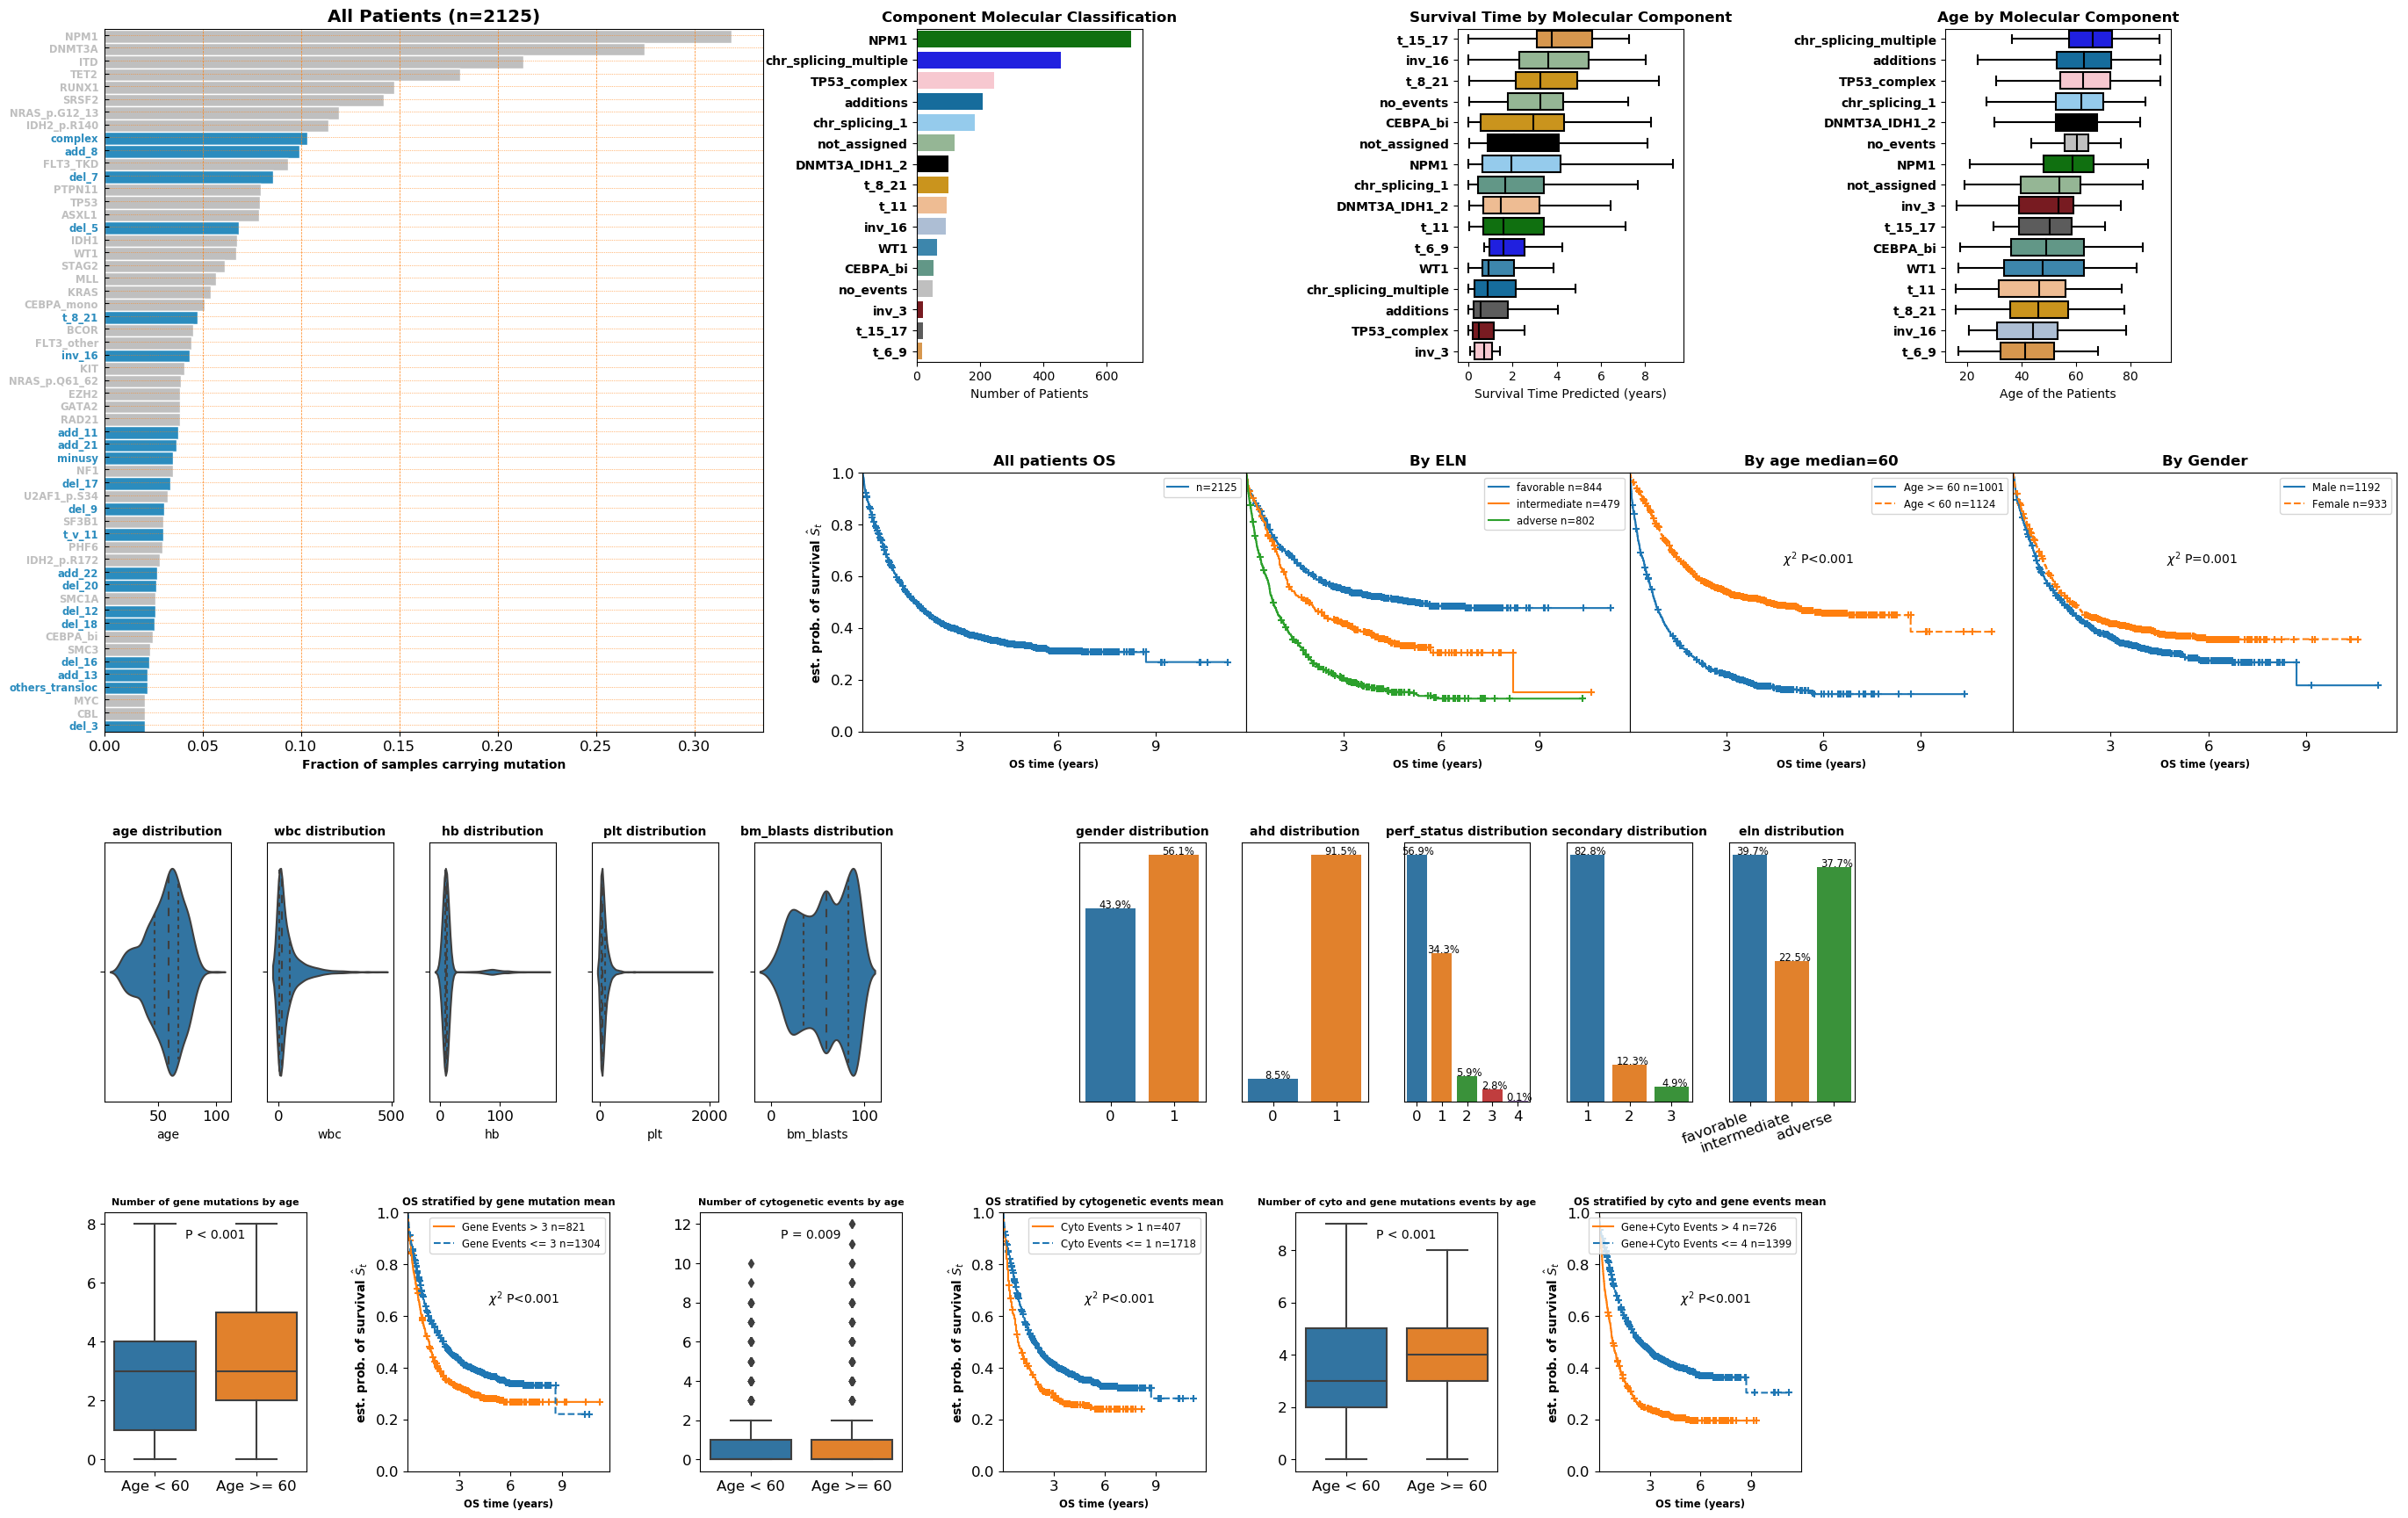

In [14]:
genes_order = df.loc[:, gene_freq_cols+cyto_freq_cols].sum(axis=0).sort_values(ascending=False).index
fig = plt.figure(figsize=(30,30))
outer = gridspec.GridSpec(nrows=29, ncols=43)
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[:5,1:12])


df_comutations = pd.DataFrame({'gene':df.sum()[genes_order].T.index, 'All patients':df.sum()[genes_order].T.values})

tot_cat = df.shape[0]
df_comutations.loc[:,'All patients' ] = df_comutations.loc[:, 'All patients']/tot_cat

df_comutations = df_comutations.reset_index()
df_comutations.gene = df_comutations.gene.astype('category')
df_comutations.gene.cat.set_categories(genes_order, inplace=True)
df_comutations.sort_values(['gene'], inplace=True)
df_comutations.gene = df_comutations.gene.astype('str')
df_comutations.set_index(['gene'],inplace=True)
del df_comutations.index.name

     
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:10, :25],wspace=0)

ax_inner = plt.Subplot(fig, inner[0])
g = sns.barplot(x=df_comutations['All patients'], y=df_comutations.index,ax=ax_inner)


gene_cyto =[]
for gene_comut in df_comutations.index:

    if(gene_comut in cyto_freq_cols):
        gene_cyto.append("cyto")
    else:
        gene_cyto.append("gene")

list_cyto = []
for i, gene_comut in enumerate(df_comutations.index):  
    if gene_comut in cyto_freq_cols:
        list_cyto.append(gene_comut)



for idx,b in enumerate(g.patches):
    b.set_color("#BFBFBF")
    if(gene_cyto[idx]=="cyto"):
        b.set_color("#2b8cbe")

    b.set_edgecolor(color='white')
    b.set_height(1.0)

g.set_xlabel('Fraction of samples carrying mutation', fontsize='medium', fontweight='bold')

major_ticks = np.arange(0, df_comutations.shape[0], 1)
#minor_ticks = np.arange(1, df_comutations.shape[0], 2)

g.set_yticks(major_ticks)
#g.set_yticks(minor_ticks, minor = True)
g.tick_params(axis = 'y', which = 'major', direction='in', pad=5)
#g.tick_params(axis = 'y', which = 'minor', labelsize = 0, length=0)
g.set_yticklabels(labels=df_comutations.index.values,fontsize='small', fontweight='bold')

for tick in g.get_yaxis().get_majorticklabels():
    tick.set_ha('right')
    tick.set_color("#BFBFBF")
    if tick.get_text() in list_cyto:
        tick.set_color('#2b8cbe')


for tick in g.get_xaxis().get_majorticklabels():
    tick.set_fontsize('large')
g.yaxis.tick_left()
g.yaxis.grid(color=sns.color_palette()[1], linestyle=':', linewidth=0.5)
g.xaxis.grid(color=sns.color_palette()[1],linestyle='--', linewidth=0.5)
g.set_title('All Patients (n=2125)', fontsize='x-large', fontweight='bold') 
fig.add_subplot(ax_inner)

###-------------------------------------------------------------------------------------------------------------------------
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:5, 15:24],wspace=0)
ax_inner = plt.Subplot(fig, inner[0])
g = sns.barplot(x=df[[c for c in df.columns if ( c.startswith( 'full' ))]].sum().sort_values(ascending=True).values,y=df[[c for c in df.columns if ( c.startswith( 'full' ))]].sum().sort_values(ascending=True).keys(),
                palette=["#EE9937","#5C5C5C","#870C14","#BFBFBF","#59A08B","#2b8cbe","#a6bddb","#fdbb84","#e79f00","#000000","darkseagreen","lightskyblue","#0072B2","pink","blue","green"],ax=ax_inner)
ax_inner.set_title("Component Molecular Classification", fontweight='bold', fontsize=12)
ax_inner.set_xlabel("Number of Patients")
ax_inner.invert_yaxis()
g.set_yticklabels(labels=[i.replace("full_component_", "") for i in df[[c for c in df.columns if ( c.startswith( 'full' ))]].sum().sort_values(ascending=True).keys()],fontsize='medium', fontweight='bold')
fig.add_subplot(ax_inner)

###-------------------------------------------------------------------------------------------------------------------------
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:5, 25:34],wspace=0)
ax_inner = plt.Subplot(fig, inner[0])

tmp =pd.DataFrame(columns=["full_component","os"])
for col in [c for c in df.columns if ( c.startswith( 'full' ))]:
    tmp_bis=pd.DataFrame(columns=["full_component","os","os_status"])
    tmp_bis.os=df[(df[col]==1)].os
    tmp_bis.os_status=df.loc[(df[col]==1)].os_status
    tmp_bis[tmp_bis.os_status==0].os=tmp_bis[tmp_bis.os_status==0].os + tmp_bis.os.std()
    tmp_bis.full_component=col
    tmp = tmp.append(tmp_bis)
g = sns.boxplot(x="os",y="full_component",data=tmp,order=tmp.groupby("full_component").mean().sort_values(by="os").index,ax=ax_inner,
                palette=["pink","#870C14","#5C5C5C","#0072B2","#2b8cbe","blue","green","#fdbb84","#59A08B","lightskyblue","#000000","#e79f00","darkseagreen","#e79f00","darkseagreen","#EE9937","#a6bddb","#BFBFBF"],
               showfliers=False)
ax_inner.set_title("Survival Time by Molecular Component", fontweight='bold', fontsize=12)
ax_inner.set_xlabel("Survival Time Predicted (years)")
ax_inner.set_ylabel("")
ax_inner.invert_yaxis()
g.set_yticklabels(labels=[i.replace("full_component_", "") for i in tmp.groupby("full_component").mean().sort_values(by="os").index],fontsize='medium', fontweight='bold')
fig.add_subplot(ax_inner)

###-------------------------------------------------------------------------------------------------------------------------
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[:5, 34:43],wspace=0)
ax_inner = plt.Subplot(fig, inner[0])

tmp =pd.DataFrame(columns=["full_component","Median_Age"])
for col in [c for c in df.columns if ( c.startswith( 'full' ))]:
    tmp_bis=pd.DataFrame(columns=["full_component","Median_Age"])
    tmp_bis.Median_Age=df[(df[col]==1) ].age
    tmp_bis.full_component=col
    tmp = tmp.append(tmp_bis)


g = sns.boxplot(x="Median_Age",y="full_component",data=tmp,order=tmp.groupby("full_component").median().sort_values(by="Median_Age").index,ax=ax_inner,
                palette=["#EE9937","#a6bddb","#e79f00","#fdbb84","#2b8cbe","#59A08B","#5C5C5C","#870C14","darkseagreen","green","#BFBFBF","#000000","lightskyblue","pink","#0072B2","blue"],
               showfliers=False)
ax_inner.set_title("Age by Molecular Component", fontweight='bold', fontsize=12)
ax_inner.set_xlabel("Age of the Patients")
ax_inner.set_ylabel("")
ax_inner.invert_yaxis()
g.set_yticklabels(labels=[i.replace("full_component_", "") for i in tmp.groupby("full_component").median().sort_values(by="Median_Age").index],fontsize='medium', fontweight='bold')
fig.add_subplot(ax_inner)

###-------------------------------------------------------------------------------------------------------------------------
inner = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[6:10,14:],wspace=0)
ax_inner = plt.Subplot(fig, inner[0])
plot_km(dataframe=df,mask_label='all',ax=ax_inner,color=sns.color_palette()[0],label='df')
   
ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('All patients OS', fontsize='large', fontweight='bold')

fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------

ax_inner = plt.Subplot(fig, inner[1])
for i,cl in enumerate(['favorable', 'intermediate', 'adverse']):
    mask = (df.eln==cl)
    plot_km(dataframe=df.loc[mask],
            mask_label=cl,
            ax=ax_inner,
            color=sns.color_palette()[i],
           label='df',label_legend=True)


ax_inner.set_yticks([])
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('By ELN', fontsize='large', fontweight='bold')

fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------

ax_inner = plt.Subplot(fig, inner[2])
df_other = df.loc[(df.age<60)]
df_slct = df.loc[(df.age>=60)]
plot_compare_km(dataframes=[df_slct, df_other],
            labels=["Age >= 60", 'Age < 60' ],
            mask_labels=[title, title],
            ax=ax_inner,
            colors=sns.color_palette()[:2],
            linestyles=['-', '--'],
            label_legend='dataset',
            test_statistic='CMH_logrank',
            xy_statistic=(0.4, 0.65),
            font_size_statistic='medium')


ax_inner.set_yticks([])
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('By age median=60', fontsize='large', fontweight='bold')

fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------
ax_inner = plt.Subplot(fig, inner[3])
# for i,cl in enumerate([0,1]):
#     mask = (df.gender==cl)
#     plot_km(dataframe=df.loc[mask],
#             mask_label=cl,
#             ax=ax_inner,
#             color=sns.color_palette()[i],
#            label='df',label_legend=True)
df_other = df.loc[(df.gender==0)]
df_slct = df.loc[(df.gender==1)]
plot_compare_km(dataframes=[df_slct, df_other],
            labels=["Male", 'Female' ],
            mask_labels=[title, title],
            ax=ax_inner,
            colors=sns.color_palette()[:2],
            linestyles=['-', '--'],
            label_legend='dataset',
            test_statistic='CMH_logrank',
            xy_statistic=(0.4, 0.65),
            font_size_statistic='medium')
ax_inner.set_yticks([])
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('By Gender', fontsize='large', fontweight='bold')

fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------

for i,cont in enumerate(["age","wbc","hb","plt","bm_blasts"]):
    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[11:15,3*i:3*(i+1)])
    ax_inner = plt.Subplot(fig, inner[0])
#     sns.boxplot(y=cont,data=df,ax=ax_inner,showfliers=False)
    sns.violinplot(x=cont,inner='quartile',data=df,ax=ax_inner)
    ax_inner.tick_params(axis='both', which='major', labelsize=12)
    #ax[i].set_xlabel('', fontsize=15, fontweight='bold')
    ax_inner.set_ylabel('')
    ax_inner.set_title(cont + ' distribution', fontsize=10, fontweight='bold')
    fig.add_subplot(ax_inner)
    
###-------------------------------------------------------------------------------------------------------------------------

for i,cat in enumerate(["gender","ahd","perf_status","secondary","eln"]):
    inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[11:15,3*(6+i):3*(7+i)])
    ax_inner = plt.Subplot(fig, inner[0])
    sns.countplot(x=cat,data=df,ax=ax_inner)
    ax_inner.tick_params(axis='both', which='major', labelsize=12)
    ax_inner.set_ylabel('')
    if  cat=="eln":
        ax_inner.set_xticklabels(ax_inner.get_xticklabels(), rotation=20, ha="right")
    ax_inner.set_xlabel('', fontsize=15, fontweight='bold')
    ax_inner.set_title(cat + ' distribution', fontsize=10, fontweight='bold')
    ax_inner.set_yticks([])
    total = float(len(df))
    for p in ax_inner.patches:
        height = p.get_height()
        ax_inner.text(p.get_x()+p.get_width()/1.7,
                height + 3,
                '{:1.1f}'.format(100*height/total)+'%',
                ha="center",fontsize='small')
    fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------
tmp = df
# tmp.loc[tmp.age<60,"age_median"]="age_inf_60"
# tmp.loc[tmp.age>=60,"age_median"]="age_sup_60"
tmp["sum_gene"] = tmp[gene_cols].sum(1)
tmp["sum_cyto"] = tmp[cyto_cols].sum(1)
tmp["sum_cyto_gene"] = tmp["sum_gene"] + tmp["sum_cyto"]
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[16:20,0:10],wspace=0.5)
ax_inner = plt.Subplot(fig, inner[0])
sns.boxplot(y="sum_gene",data=tmp,x="age_median",ax=ax_inner,showfliers=False)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.set_xticklabels(["Age < 60","Age >= 60"])
ax_inner.set_xlabel('', fontsize=15, fontweight='bold')
ax_inner.set_ylabel('')
ax_inner.set_title("Number of gene mutations by age" , fontsize=8, fontweight='bold')
statistic, p_value = ranksums(df.loc[df["age_median"]==0,"sum_gene"].dropna().values,df.loc[df["age_median"]==1,"sum_gene"].dropna().values)
if p_value<0.001:
    s='P < 0.001'
else:
    s='P = %.3f'%p_value
ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='medium')
fig.add_subplot(ax_inner)
ax_inner = plt.Subplot(fig, inner[1])
                       
df_other = tmp.loc[(tmp.sum_gene<=round(tmp.sum_gene.mean()))]
df_slct = tmp.loc[(tmp.sum_gene>round(tmp.sum_gene.mean()))]
plot_compare_km(dataframes=[df_slct, df_other],
            labels=["Gene Events > "+str(round(tmp.sum_gene.mean())), "Gene Events <= "+str(round(tmp.sum_gene.mean())) ],
            mask_labels=[title, title],
            ax=ax_inner,
            colors=[sns.color_palette()[1],sns.color_palette()[0]],
            linestyles=['-', '--'],
            label_legend='dataset',
            test_statistic='CMH_logrank',
            xy_statistic=(0.4, 0.65),
            font_size_statistic='medium')


ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('OS stratified by gene mutation mean', fontsize='small', fontweight='bold')
fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------

inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[16:20,11:21],wspace=0.5)
ax_inner = plt.Subplot(fig, inner[0])
sns.boxplot(y="sum_cyto",data=tmp,x="age_median",ax=ax_inner)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.set_xticklabels(["Age < 60","Age >= 60"])
ax_inner.set_xlabel('', fontsize=15, fontweight='bold')
ax_inner.set_ylabel('')
ax_inner.set_title("Number of cytogenetic events by age", fontsize=8, fontweight='bold')
statistic, p_value = ranksums(df.loc[df["age_median"]==0,"sum_cyto"].dropna().values,df.loc[df["age_median"]==1,"sum_cyto"].dropna().values)
if p_value<0.001:
    s='P < 0.001'
else:
    s='P = %.3f'%p_value
ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='medium')
fig.add_subplot(ax_inner)
ax_inner = plt.Subplot(fig, inner[1])

df_other = tmp.loc[(tmp.sum_cyto<=round(tmp.sum_cyto.mean()))]
df_slct = tmp.loc[(tmp.sum_cyto>round(tmp.sum_cyto.mean()))]
plot_compare_km(dataframes=[df_slct, df_other],
            labels=["Cyto Events > "+str(round(tmp.sum_cyto.mean())), "Cyto Events <= "+str(round(tmp.sum_cyto.mean())) ],
            mask_labels=[title, title],
            ax=ax_inner,
            colors=[sns.color_palette()[1],sns.color_palette()[0]],
            linestyles=['-', '--'],
            label_legend='dataset',
            test_statistic='CMH_logrank',
            xy_statistic=(0.4, 0.65),
            font_size_statistic='medium')

ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('OS stratified by cytogenetic events mean', fontsize='small', fontweight='bold')
fig.add_subplot(ax_inner)
###-------------------------------------------------------------------------------------------------------------------------

inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[16:20,22:32],wspace=0.5)
ax_inner = plt.Subplot(fig, inner[0])
sns.boxplot(y="sum_cyto_gene",data=tmp,x="age_median",ax=ax_inner,showfliers=False)
statistic, p_value = ranksums(df.loc[df["age_median"]==0,"sum_cyto_gene"].dropna().values,df.loc[df["age_median"]==1,"sum_cyto_gene"].dropna().values)
if p_value<0.001:
    s='P < 0.001'
else:
    s='P = %.3f'%p_value
ax_inner.annotate(s=s, xy=(0.4,0.9), xycoords='axes fraction', fontsize='medium')
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.set_xticklabels(["Age < 60","Age >= 60"])
ax_inner.set_xlabel('', fontsize=15, fontweight='bold')
ax_inner.set_ylabel('')
ax_inner.set_title("Number of cyto and gene mutations events by age", fontsize=8, fontweight='bold')
fig.add_subplot(ax_inner)
ax_inner = plt.Subplot(fig, inner[1])

df_other = tmp.loc[(tmp.sum_cyto_gene<=round(tmp.sum_cyto_gene.mean()))]
df_slct = tmp.loc[(tmp.sum_cyto_gene>round(tmp.sum_cyto_gene.mean()))]
plot_compare_km(dataframes=[df_slct, df_other],
            labels=["Gene+Cyto Events > "+str(round(tmp.sum_cyto_gene.mean())), "Gene+Cyto Events <= "+str(round(tmp.sum_cyto_gene.mean())) ],
            mask_labels=[title, title],
            ax=ax_inner,
            colors=[sns.color_palette()[1],sns.color_palette()[0]],
            linestyles=['-', '--'],
            label_legend='dataset',
            test_statistic='CMH_logrank',
            xy_statistic=(0.4, 0.65),
            font_size_statistic='medium')

ax_inner.set_ylabel('est. prob. of survival $\hat{S}_t$', fontsize='medium', fontweight='bold')
ax_inner.set_xlabel('OS time (years)', fontsize='small', fontweight='bold')
ax_inner.set_xlim(left=0.)
ax_inner.tick_params(axis='both', which='major', labelsize=12)
ax_inner.xaxis.set_major_locator(MaxNLocator(nbins=5, prune='lower', integer=True))
ax_inner.set_ylim([0.,1.])
ax_inner.legend(loc='upper right', fontsize='small')
ax_inner.set_title('OS stratified by cyto and gene events mean', fontsize='small', fontweight='bold')
fig.add_subplot(ax_inner)


fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.90, wspace=2, hspace=1) 
fig.savefig('graphs/Overall Summary.png' , format='png')

# CONCAT ALL PDFS

In [11]:
import os
from PyPDF2 import PdfFileMerger

pdfs = os.listdir("graphs/summary_components/")
merger = PdfFileMerger()
for pdf in pdfs:
    if("pdf" in pdf):
          merger.append("graphs/summary_components/"+pdf)

merger.write("graphs/ALL_COMPONENTS.pdf")
merger.close()

In [19]:
tmp =pd.DataFrame(columns=["full_component","os"])
for col in [c for c in df.columns if ( c.startswith( 'full' ))]:
    tmp_bis=pd.DataFrame(columns=["full_component","os","os_status"])
    tmp_bis.os=df[(df[col]==1)].os
    tmp_bis.os_status=df.loc[(df[col]==1)].os_status
    tmp_bis[tmp_bis.os_status==0].os=tmp_bis[tmp_bis.os_status==0].os + tmp_bis.os.std()
    tmp_bis.full_component=col
    tmp = tmp.append(tmp_bis)
order=tmp.groupby("full_component").mean().sort_values(by="os",ascending=False).index

pdfs = os.listdir("graphs/summary_components/")
merger = PdfFileMerger()
for pdf in order:
      merger.append("graphs/summary_components/summary_"+pdf+".pdf")

merger.write("graphs/ALL_COMPONENTS.pdf")
merger.close()

In [17]:
for pdf in order:
    print("graphs/summary_components/summary_"+pdf+".pdf")

graphs/summary_components/summary_full_component_t_15_17.pdf
graphs/summary_components/summary_full_component_inv_16.pdf
graphs/summary_components/summary_full_component_t_8_21.pdf
graphs/summary_components/summary_full_component_no_events.pdf
graphs/summary_components/summary_full_component_CEBPA_bi.pdf
graphs/summary_components/summary_full_component_not_assigned.pdf
graphs/summary_components/summary_full_component_NPM1.pdf
graphs/summary_components/summary_full_component_chr_splicing_1.pdf
graphs/summary_components/summary_full_component_DNMT3A_IDH1_2.pdf
graphs/summary_components/summary_full_component_t_11.pdf
graphs/summary_components/summary_full_component_t_6_9.pdf
graphs/summary_components/summary_full_component_WT1.pdf
graphs/summary_components/summary_full_component_chr_splicing_multiple.pdf
graphs/summary_components/summary_full_component_additions.pdf
graphs/summary_components/summary_full_component_TP53_complex.pdf
graphs/summary_components/summary_full_component_inv_3.pd

In [18]:
for pdf in pdfs:
    print (pdf)

summary_full_component_chr_splicing_multiple.pdf
summary_full_component_TP53_complex.pdf
summary_full_component_additions.pdf
summary_full_component_no_events.pdf
summary_full_component_chr_splicing_1.pdf
summary_full_component_CEBPA_bi.pdf
summary_full_component_t_11.pdf
summary_full_component_DNMT3A_IDH1_2.pdf
summary_full_component_NPM1.pdf
summary_full_component_not_assigned.pdf
summary_full_component_t_8_21.pdf
summary_full_component_inv_3.pdf
summary_full_component_WT1.pdf
summary_full_component_inv_16.pdf
.ipynb_checkpoints
summary_full_component_t_6_9.pdf
summary_full_component_t_15_17.pdf
